# Dynamic Re-analysis: RNA-seq workflow gene-level exploratory analysis and differential expression

The following workflow reproduced from  https://www.bioconductor.org/help/workflows/rnaseqGene/#introduction 

*Authors*: Michael I. Love, Simon Anders, Vladislav Kim and Wolfgang Huber

The workflow deals with an end-to-end gene-level RNA-seq differential expression using Bioconductor packages reproduced on a Jupyter notebook. We will start from the FASTQ files, show how these were aligned to the reference genome, and prepare a count matrix which tallies the number of RNA-seq reads/fragments within each gene for each sample. We will perform exploratory data analysis (EDA) for quality assessment and to explore the relationship between samples, perform differential gene expression analysis, and visually explore the results.

## Introduction

Bioconductor has many packages which support analysis of high-throughput sequence data, including RNA sequencing (RNA-seq). The packages which we will use in this workflow include core packages maintained by the Bioconductor core team for importing and processing raw sequencing data and loading gene annotations. We will also use contributed packages for statistical analysis and visualization of sequencing data. 

### Experimental Data

The data used in this workflow is stored in the airway[2] package that summarizes an RNA-seq experiment wherein airway smooth muscle cells were treated with dexamethasone, a synthetic glucocorticoid steroid with anti-inflammatory effects (Himes et al. 2014). Glucocorticoids are used, for example, by people with asthma to reduce inflammation of the airways. In the experiment, four primary human airway smooth muscle cell lines were treated with 1 micromolar dexamethasone for 18 hours. For each of the four cell lines, we have a treated and an untreated sample.

## Preparing Count Matrices

As input, the count-based statistical methods, such as [DESeq2](http://bioconductor.org/packages/DESeq2) (Love, Huber, and Anders 2014) [8], [edgeR](http://bioconductor.org/packages/edgeR) (M. D. Robinson, McCarthy, and Smyth 2009), [limma](http://bioconductor.org/packages/limma) with the voom method (Law et al. 2014), [DSS](http://bioconductor.org/packages/DSS) (H. Wu, Wang, and Wu 2013), [EBSeq](http://bioconductor.org/packages/EBSeq) (Leng et al. 2013) and [baySeq](http://bioconductor.org/packages/baySeq) (Hardcastle and Kelly 2010), expect input data as obtained, e.g., from RNA-seq or another high-throughput sequencing experiment, in the form of a matrix of integer values. The value in the i-th row and the j-th column of the matrix tells how many reads (or fragments, for paired-end RNA-seq) have been assigned to gene i in sample j. Analogously, for other types of assays, the rows of the matrix might correspond e.g., to binding regions (with ChIP-Seq), species of bacteria (with metagenomic datasets), or peptide sequences (with quantitative mass spectrometry).

The values in the matrix should be counts of sequencing reads/fragments. This is important for DESeq2’s statistical model to hold, as only counts allow assessing the measurement precision correctly. It is important to never provide counts that were pre-normalized for sequencing depth/library size, as the statistical model is most powerful when applied to un-normalized counts, and is designed to account for library size differences internally.

### Aligning read to a reference genome

The computational analysis of an RNA-seq experiment begins from the FASTQ files that contain the nucleotide sequence of each read and a quality score at each position. These reads must first be aligned to a reference genome or transcriptome, or the abundances and estimated counts per transcript can be estimated without alignment, as described above. In either case, it is important to know if the sequencing experiment was single-end or paired-end, as the alignment software will require the user to specify both FASTQ files for a paired-end experiment. The output of this alignment step is commonly stored in a file format called [SAM/BAM](http://samtools.github.io/hts-specs).

A number of software programs exist to align reads to a reference genome, and we encourage you to check out some of the benchmarking papers that discuss the advantages and disadvantages of each software, which include accuracy, sensitivity in aligning reads over splice junctions, speed, memory required, usability, and many other features. Here, we used the STAR read aligner (Dobin et al. 2013) to align the reads for our current experiment to the Ensembl release 75 (Flicek et al. 2014) human reference genome. In the following code example, it is assumed that there is a file in the current directory called <span style="color:green">files</span> with each line containing an identifier for each experiment, and we have all the FASTQ files in a subdirectory <span style="color:green">fastq</span>. If you have downloaded the FASTQ files from the Sequence Read Archive, the identifiers would be SRA run IDs, e.g. <span style="color:green">SRR1039520</span>. You should have two files for a paired-end experiment for each ID, <span style="color:green">fastq/SRR1039520_1.fastq</span> and <span style="color:green">fastq/SRR1039520_2.fastq</span>, which give the first and second read for the paired-end fragments. If you have performed a single-end experiment, you would only have one file per ID. We have also created a subdirectory, <span style="color:green">aligned</span>, where STAR will output its alignment files.

    for f in `cat files`; do STAR --genomeDir ../STAR/ENSEMBL.homo_sapiens.release-75 \
    --readFilesIn fastq/$f\_1.fastq fastq/$f\_2.fastq \
    --runThreadN 12 --outFileNamePrefix aligned/$f.; done

[SAMtools](http://www.htslib.org/doc/samtools.html) (H. Li et al. 2009) was used to generate BAM files. The -@ flag can be used to allocate additional threads.

    for f in `cat files`; do samtools view -bS aligned/$f.Aligned.out.sam \
-o aligned/$f.bam; done

The BAM files for a number of sequencing runs can then be used to generate count matrices, as described in the following section.

In [8]:
# Loading the requisite libraries and precomputation commands
suppressPackageStartupMessages(library("BiocStyle"))
suppressPackageStartupMessages(library("knitr"))
suppressPackageStartupMessages(library("rmarkdown"))

# to hide warnings
options(warn = -1)

Warning message:
"package 'knitr' was built under R version 3.3.3"Warning message:
"package 'rmarkdown' was built under R version 3.3.3"

Installing requisite packages

### Locating alignment files

Besides the count matrix that we will use later, the airway[2] package also contains eight files with a small subset of the total number of reads in the experiment. The reads were selected which aligned to a small region of chromosome 1. Here, for demonstration, we chose a subset of reads because the full alignment files are large (a few gigabytes each), and because it takes between 10-30 minutes to count the fragments for each sample. We will use these files to demonstrate how a count matrix can be constructed from BAM files. Afterwards, we will load the full count matrix corresponding to all samples and all data, which is already provided in the same package, and will continue the analysis with that full matrix.

We load the data package with the example data:

In [9]:
## Loading airway smooth muscle cell package package
suppressPackageStartupMessages(library("airway"))

The R function system.file can be used to find out where on your computer the files from a package have been installed. Here we ask for the full path to the extdata directory, where R packages store external data, that is part of the [airway](http://bioconductor.org/packages/airway) [2] package.

In [10]:
## Specifying external directory for the bioconductor package
indir <- system.file("extdata", package="airway", mustWork=TRUE)
print("List of Files in the /extdata directory of the airway package:")
list.files(indir)

[1] "List of Files in the /extdata directory of the airway package:"


[1] "GSE52778_series_matrix.txt"        "Homo_sapiens.GRCh37.75_subset.gtf"
 [3] "sample_table.csv"                  "SraRunInfo_SRP033351.csv"         
 [5] "SRR1039508_subset.bam"             "SRR1039509_subset.bam"            
 [7] "SRR1039512_subset.bam"             "SRR1039513_subset.bam"            
 [9] "SRR1039516_subset.bam"             "SRR1039517_subset.bam"            
[11] "SRR1039520_subset.bam"             "SRR1039521_subset.bam"

Typically, we have a table with detailed information for each of our samples that links samples to the associated FASTQ and BAM files. For your own project, you might create such a comma-separated value (CSV) file using a text editor or spreadsheet software such as Excel.
We load such a CSV file with read.csv:

In [11]:
# accessing the sample table from the airway package.
csvfile <- file.path(indir, "sample_table.csv")
sampleTable <- read.csv(csvfile, row.names = 1)
sampleTable

,SampleName,cell,dex,albut,Run,avgLength,Experiment,Sample,BioSample
SRR1039508,GSM1275862,N61311,untrt,untrt,SRR1039508,126,SRX384345,SRS508568,SAMN02422669
SRR1039509,GSM1275863,N61311,trt,untrt,SRR1039509,126,SRX384346,SRS508567,SAMN02422675
SRR1039512,GSM1275866,N052611,untrt,untrt,SRR1039512,126,SRX384349,SRS508571,SAMN02422678
SRR1039513,GSM1275867,N052611,trt,untrt,SRR1039513,87,SRX384350,SRS508572,SAMN02422670
SRR1039516,GSM1275870,N080611,untrt,untrt,SRR1039516,120,SRX384353,SRS508575,SAMN02422682
SRR1039517,GSM1275871,N080611,trt,untrt,SRR1039517,126,SRX384354,SRS508576,SAMN02422673
SRR1039520,GSM1275874,N061011,untrt,untrt,SRR1039520,101,SRX384357,SRS508579,SAMN02422683
SRR1039521,GSM1275875,N061011,trt,untrt,SRR1039521,98,SRX384358,SRS508580,SAMN02422677


Once the reads have been aligned, there are a number of tools that can be used to count the number of reads/fragments that can be assigned to genomic features for each sample. These often take as input SAM/BAM alignment files and a file specifying the genomic features, e.g. a GFF3 or GTF file specifying the gene models

In [12]:
## Checking for the existance of files in the package directory.
filenames <- file.path(indir, paste0(sampleTable$Run, "_subset.bam"))
unique(sampleTable$Run)
file.exists(filenames)

[1] SRR1039508 SRR1039509 SRR1039512 SRR1039513 SRR1039516 SRR1039517 SRR1039520
[8] SRR1039521
8 Levels: SRR1039508 SRR1039509 SRR1039512 SRR1039513 ... SRR1039521

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

**DESeq2 import functions**

The following tools can be used generate count matrices: summarizeOverlaps (Lawrence et al. 2013), featureCounts (Liao, Smyth, and Shi 2014), tximport (Soneson, Love, and Robinson 2015), htseq-count (Anders, Pyl, and Huber 2015).


| **function** | **package** | **framework** | **output** | **DESeq2 input function** |
|---|---|---|---|---|
| summarizeOverlaps | GenomicAlignments | R/Bioconductor | SummarizedExperiment | DESeqDataSet |
| featureCounts | Rsubread | R/Bioconductor | matrix | DESeqDataSetFromMatrix |
| tximport | tximport | R/Bioconductor | list of matrices | DESeqDataSetFromTximport |
| htseq-count | HTSeq | Python | files | DESeqDataSetFromHTSeq |

We now proceed using summarizeOverlaps. Using the Run column in the sample table, we construct the full paths to the files we want to perform the counting operation on:

In [13]:
## Bam files list from the Rsamtools[3] package

suppressPackageStartupMessages(library("Rsamtools"))

bamfiles <- BamFileList(filenames, yieldSize=2000000)

## The sequence Info
seqinfo(bamfiles[1])

Seqinfo object with 84 sequences from an unspecified genome:
  seqnames   seqlengths isCircular genome
  1           249250621       <NA>   <NA>
  10          135534747       <NA>   <NA>
  11          135006516       <NA>   <NA>
  12          133851895       <NA>   <NA>
  13          115169878       <NA>   <NA>
  ...               ...        ...    ...
  GL000210.1      27682       <NA>   <NA>
  GL000231.1      27386       <NA>   <NA>
  GL000229.1      19913       <NA>   <NA>
  GL000226.1      15008       <NA>   <NA>
  GL000207.1       4262       <NA>   <NA>

**Note:** 
Make sure that the chromosome names of the genomic features in the annotation you use are consistent with the chromosome names of the reference used for read alignment. Otherwise, the scripts might fail to count any reads to features due to the mismatching names. For example, a common mistake is when the alignment files contain chromosome names in the style of 1 and the gene annotation in the style of chr1, or the other way around. See the seqlevelsStyle function in the GenomeInfoDb package for solutions. We can check the chromosome names (here called “seqnames”) in the alignment files like so:

### Defining gene models

Next, we need to read in the gene model that will be used for counting reads/fragments. We will read the gene model from an Ensembl GTF file (Flicek et al. 2014), using makeTxDbFromGFF from the GenomicFeatures[5] package. GTF files can be downloaded from Ensembl’s FTP site or other gene model repositories. A TxDb object is a database that can be used to generate a variety of range-based objects, such as exons, transcripts, and genes. We want to make a list of exons grouped by gene for counting read/fragments.

There are other options for constructing a TxDb. For the known genes track from the UCSC Genome Browser (Kent et al. 2002), one can use the pre-built Transcript DataBase: TxDb.Hsapiens.UCSC.hg19.knownGene. If the annotation file is accessible from AnnotationHub (as is the case for the Ensembl genes), a pre-scanned GTF file can be imported using makeTxDbFromGRanges.
Here we will demonstrate loading from a GTF file:

In [14]:
suppressPackageStartupMessages(library("GenomicFeatures"))

## txdb format
gtffile <- file.path(indir,"Homo_sapiens.GRCh37.75_subset.gtf")
txdb <- makeTxDbFromGFF(gtffile, format = "gtf", circ_seqs = character())
txdb

Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... OK


TxDb object:
# Db type: TxDb
# Supporting package: GenomicFeatures
# Data source: C:/Users/Yash/Documents/R/win-library/3.3/airway/extdata/Homo_sapiens.GRCh37.75_subset.gtf
# Organism: NA
# Taxonomy ID: NA
# miRBase build ID: NA
# Genome: NA
# transcript_nrow: 65
# exon_nrow: 279
# cds_nrow: 158
# Db created by: GenomicFeatures package from Bioconductor
# Creation time: 2017-05-14 23:01:00 -0700 (Sun, 14 May 2017)
# GenomicFeatures version at creation time: 1.26.4
# RSQLite version at creation time: 1.1-2
# DBSCHEMAVERSION: 1.1

The following line produces a GRangesList of all the exons grouped by gene (Lawrence et al. 2013). Each element of the list is a GRanges object of the exons for a gene.


In [15]:
ebg <- exonsBy(txdb, by="gene")
ebg

GRangesList object of length 20:
$ENSG00000009724 
GRanges object with 18 ranges and 2 metadata columns:
       seqnames               ranges strand |   exon_id       exon_name
          <Rle>            <IRanges>  <Rle> | <integer>     <character>
   [1]        1 [11086580, 11087705]      - |        98 ENSE00000818830
   [2]        1 [11090233, 11090307]      - |        99 ENSE00000472123
   [3]        1 [11090805, 11090939]      - |       100 ENSE00000743084
   [4]        1 [11094885, 11094963]      - |       101 ENSE00000743085
   [5]        1 [11097750, 11097868]      - |       102 ENSE00003482788
   ...      ...                  ...    ... .       ...             ...
  [14]        1 [11106948, 11107176]      - |       111 ENSE00003467404
  [15]        1 [11106948, 11107176]      - |       112 ENSE00003489217
  [16]        1 [11107260, 11107280]      - |       113 ENSE00001833377
  [17]        1 [11107260, 11107284]      - |       114 ENSE00001472289
  [18]        1 [11107260, 1110

### Read counting steps

After these preparations, the actual counting is easy. The function summarizeOverlaps from the GenomicAlignments[6] package will do this. This produces a SummarizedExperiment object that contains a variety of information about the experiment, and will be described in more detail below.

**Note:** If it is desired to perform counting using multiple cores, one can use the register and MulticoreParam or SnowParam functions from the BiocParallel[7] package before the counting call below. Expect that the summarizeOverlaps call will take at least 30 minutes per file for a human RNA-seq file with 30 million aligned reads. By sending the files to separate cores, one can speed up the entire counting process.

In [16]:
suppressPackageStartupMessages(library("GenomicAlignments"))
suppressPackageStartupMessages(library("BiocParallel"))

# register(MulitcoreParam())
register(SerialParam())

## ------------------------------------------------------------------------
se <- summarizeOverlaps(features=ebg, reads=bamfiles,
                        mode="Union",
                        singleEnd=FALSE,
                        ignore.strand=TRUE,
                        fragments=TRUE)


After these preparations, the actual counting is easy. The function summarizeOverlaps from the GenomicAlignments[6] package will do this. This produces a SummarizedExperiment object that contains a variety of information about the experiment, and will be described in more detail below.

**Note:** If it is desired to perform counting using multiple cores, one can use the register and MulticoreParam or SnowParam functions from the BiocParallel[7] package before the counting call below. Expect that the summarizeOverlaps call will take at least 30 minutes per file for a human RNA-seq file with 30 million aligned reads. By sending the files to separate cores, one can speed up the entire counting process.

[1] "Summarized Experiment"


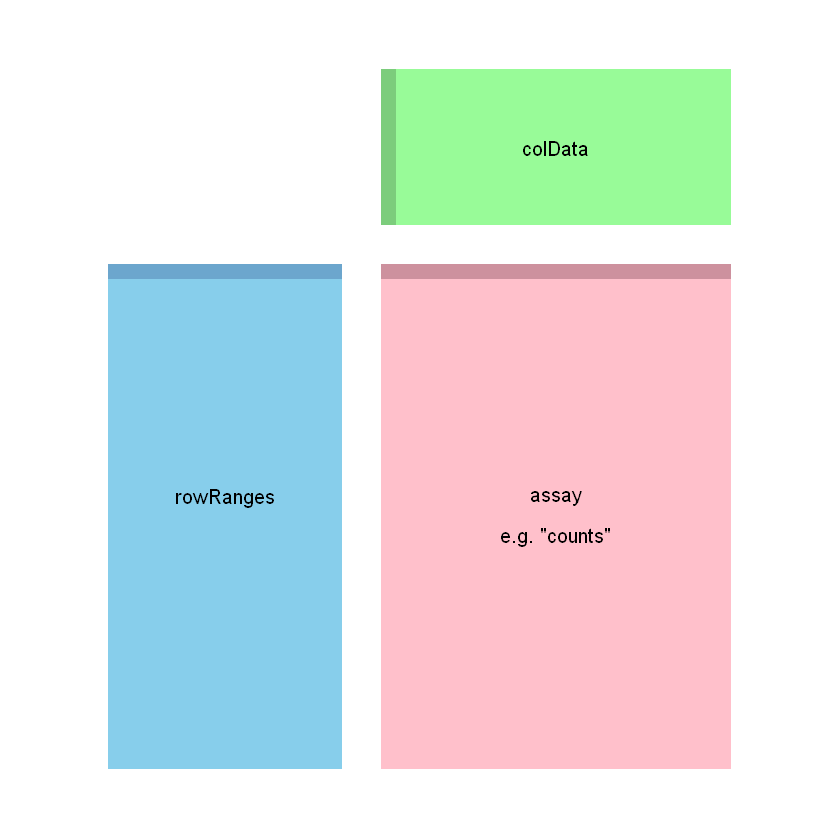

In [17]:
## ----sumexp, echo=FALSE--------------------------------------------------
par(mar=c(0,0,0,0))
plot(1,1,xlim=c(0,100),ylim=c(0,100),bty="n",
     type="n",xlab="",ylab="",xaxt="n",yaxt="n")
polygon(c(45,90,90,45),c(5,5,70,70),col="pink",border=NA)
polygon(c(45,90,90,45),c(68,68,70,70),col="pink3",border=NA)
text(67.5,40,"assay")
text(67.5,35,'e.g. "counts"')
polygon(c(10,40,40,10),c(5,5,70,70),col="skyblue",border=NA)
polygon(c(10,40,40,10),c(68,68,70,70),col="skyblue3",border=NA)
text(25,40,"rowRanges")
polygon(c(45,90,90,45),c(75,75,95,95),col="palegreen",border=NA)
polygon(c(45,47,47,45),c(75,75,95,95),col="palegreen3",border=NA)
text(67.5,85,"colData")

print("Summarized Experiment")

In [18]:
se
dim(se)
assayNames(se)

class: RangedSummarizedExperiment 
dim: 20 8 
metadata(0):
assays(1): counts
rownames(20): ENSG00000009724 ENSG00000116649 ... ENSG00000271794
  ENSG00000271895
rowData names(0):
colnames(8): SRR1039508_subset.bam SRR1039509_subset.bam ...
  SRR1039520_subset.bam SRR1039521_subset.bam
colData names(0):

[1] 20  8

[1] "counts"

The *rowRanges*, when printed, only shows the first GRanges, and tells us there are 19 more elements:

In [19]:
print("Row summary")
rowRanges(se)

[1] "Row summary"


GRangesList object of length 20:
$ENSG00000009724 
GRanges object with 18 ranges and 2 metadata columns:
       seqnames               ranges strand |   exon_id       exon_name
          <Rle>            <IRanges>  <Rle> | <integer>     <character>
   [1]        1 [11086580, 11087705]      - |        98 ENSE00000818830
   [2]        1 [11090233, 11090307]      - |        99 ENSE00000472123
   [3]        1 [11090805, 11090939]      - |       100 ENSE00000743084
   [4]        1 [11094885, 11094963]      - |       101 ENSE00000743085
   [5]        1 [11097750, 11097868]      - |       102 ENSE00003482788
   ...      ...                  ...    ... .       ...             ...
  [14]        1 [11106948, 11107176]      - |       111 ENSE00003467404
  [15]        1 [11106948, 11107176]      - |       112 ENSE00003489217
  [16]        1 [11107260, 11107280]      - |       113 ENSE00001833377
  [17]        1 [11107260, 11107284]      - |       114 ENSE00001472289
  [18]        1 [11107260, 1110

The rowRanges also contains metadata about the construction of the gene model in the metadata slot. Here we use a helpful R function, str, to display the metadata compactly:

In [20]:
str(metadata(rowRanges(se)))

# column Data
colData(se)

List of 1
 $ genomeInfo:List of 15
  ..$ Db type                                 : chr "TxDb"
  ..$ Supporting package                      : chr "GenomicFeatures"
  ..$ Data source                             : chr "C:/Users/Yash/Documents/R/win-library/3.3/airway/extdata/Homo_sapiens.GRCh37.75_subset.gtf"
  ..$ Organism                                : chr NA
  ..$ Taxonomy ID                             : chr NA
  ..$ miRBase build ID                        : chr NA
  ..$ Genome                                  : chr NA
  ..$ transcript_nrow                         : chr "65"
  ..$ exon_nrow                               : chr "279"
  ..$ cds_nrow                                : chr "158"
  ..$ Db created by                           : chr "GenomicFeatures package from Bioconductor"
  ..$ Creation time                           : chr "2017-05-14 23:01:00 -0700 (Sun, 14 May 2017)"
  ..$ GenomicFeatures version at creation time: chr "1.26.4"
  ..$ RSQLite version at creation time    

DataFrame with 8 rows and 0 columns

In [21]:
head(assay(se), 5)
colSums(assay(se))

,SRR1039508_subset.bam,SRR1039509_subset.bam,SRR1039512_subset.bam,SRR1039513_subset.bam,SRR1039516_subset.bam,SRR1039517_subset.bam,SRR1039520_subset.bam,SRR1039521_subset.bam
ENSG00000009724,38,28,66,24,42,41,47,36
ENSG00000116649,1004,1255,1122,1313,1100,1879,745,1536
ENSG00000120942,218,256,233,252,269,465,207,400
ENSG00000120948,2751,2080,3353,1614,3519,3716,2220,1990
ENSG00000171819,4,50,19,543,1,10,14,1067


SRR1039508_subset.bam SRR1039509_subset.bam SRR1039512_subset.bam 
                 6478                  6501                  7699 
SRR1039513_subset.bam SRR1039516_subset.bam SRR1039517_subset.bam 
                 6801                  8009                 10849 
SRR1039520_subset.bam SRR1039521_subset.bam 
                 5254                  9168

In [22]:
colData(se) <- DataFrame(sampleTable)
colData(se)

DataFrame with 8 rows and 9 columns
           SampleName     cell      dex    albut        Run avgLength
             <factor> <factor> <factor> <factor>   <factor> <integer>
SRR1039508 GSM1275862   N61311    untrt    untrt SRR1039508       126
SRR1039509 GSM1275863   N61311      trt    untrt SRR1039509       126
SRR1039512 GSM1275866  N052611    untrt    untrt SRR1039512       126
SRR1039513 GSM1275867  N052611      trt    untrt SRR1039513        87
SRR1039516 GSM1275870  N080611    untrt    untrt SRR1039516       120
SRR1039517 GSM1275871  N080611      trt    untrt SRR1039517       126
SRR1039520 GSM1275874  N061011    untrt    untrt SRR1039520       101
SRR1039521 GSM1275875  N061011      trt    untrt SRR1039521        98
           Experiment    Sample    BioSample
             <factor>  <factor>     <factor>
SRR1039508  SRX384345 SRS508568 SAMN02422669
SRR1039509  SRX384346 SRS508567 SAMN02422675
SRR1039512  SRX384349 SRS508571 SAMN02422678
SRR1039513  SRX384350 SRS508572 SAMN024

The colData slot, so far empty, should contain all the metadata. Because we used a column of sampleTable to produce the bamfiles vector, we know the columns of se are in the same order as the rows of sampleTable. We can assign the sampleTable as the colData of the summarized experiment, by converting it into a DataFrame and using the assignment function:

### Branching point

At this point, we have counted the fragments which overlap the genes in the gene model we specified. This is a branching point where we could use a variety of Bioconductor packages for exploration and differential expression of the count data, including edgeR (M. D. Robinson, McCarthy, and Smyth 2009), limma with the voom method (Law et al. 2014), DSS (H. Wu, Wang, and Wu 2013), EBSeq (Leng et al. 2013) and baySeq (Hardcastle and Kelly 2010). Schurch et al. (2016) compared performance of different statistical methods for RNA-seq using a large number of biological replicates and can help users to decide which tools make sense to use, and how many biological replicates are necessary to obtain a certain sensitivity. We will continue using DESeq2 (Love, Huber, and Anders 2014). The SummarizedExperiment object is all we need to start our analysis. In the following section we will show how to use it to create the data object used by DESeq2.

In [23]:
se$cell
se$dex

[1] N61311  N61311  N052611 N052611 N080611 N080611 N061011 N061011
Levels: N052611 N061011 N080611 N61311

[1] untrt trt   untrt trt   untrt trt   untrt trt  
Levels: trt untrt

**Note:** it is prefered in R that the first level of a factor be the reference level (e.g. control, or untreated samples), so we can relevel the dex factor like so:

In [24]:
## ----sedex---------------------------------------------------------------
library("magrittr")
se$dex %<>% relevel("untrt")
se$dex

[1] untrt trt   untrt trt   untrt trt   untrt trt  
Levels: untrt trt

%<>% is the compound assignment pipe-operator from the magrittr package, the above line of code is a concise way of saying

### Starting from summarized expriment

We now use R’s data command to load a prepared SummarizedExperiment that was generated from the publicly available sequencing data files associated with Himes et al. (2014), described above. The steps we used to produce this object were equivalent to those you worked through in the previous sections, except that we used all the reads and all the genes. For more details on the exact steps used to create this object, type vignette("airway") into your R session

In [25]:
## ----explaincmpass, eval = FALSE-----------------------------------------
## se$dex <- relevel(se$dex, "untrt")

## ------------------------------------------------------------------------
data("airway")
se <- airway

## ------------------------------------------------------------------------
se$dex %<>% relevel("untrt")
se$dex

## ------------------------------------------------------------------------
round( colSums(assay(se)) / 1e6, 1 )

## ------------------------------------------------------------------------
colData(se)


[1] untrt trt   untrt trt   untrt trt   untrt trt  
Levels: untrt trt

SRR1039508 SRR1039509 SRR1039512 SRR1039513 SRR1039516 SRR1039517 SRR1039520 
      20.6       18.8       25.3       15.2       24.4       30.8       19.1 
SRR1039521 
      21.2

DataFrame with 8 rows and 9 columns
           SampleName     cell      dex    albut        Run avgLength
             <factor> <factor> <factor> <factor>   <factor> <integer>
SRR1039508 GSM1275862   N61311    untrt    untrt SRR1039508       126
SRR1039509 GSM1275863   N61311      trt    untrt SRR1039509       126
SRR1039512 GSM1275866  N052611    untrt    untrt SRR1039512       126
SRR1039513 GSM1275867  N052611      trt    untrt SRR1039513        87
SRR1039516 GSM1275870  N080611    untrt    untrt SRR1039516       120
SRR1039517 GSM1275871  N080611      trt    untrt SRR1039517       126
SRR1039520 GSM1275874  N061011    untrt    untrt SRR1039520       101
SRR1039521 GSM1275875  N061011      trt    untrt SRR1039521        98
           Experiment    Sample    BioSample
             <factor>  <factor>     <factor>
SRR1039508  SRX384345 SRS508568 SAMN02422669
SRR1039509  SRX384346 SRS508567 SAMN02422675
SRR1039512  SRX384349 SRS508571 SAMN02422678
SRR1039513  SRX384350 SRS508572 SAMN024

Here we see that this object already contains an informative colData slot – because we have already prepared it for you, as described in the airway vignette. However, when you work with your own data, you will have to add the pertinent sample / phenotypic information for the experiment at this stage. We highly recommend keeping this information in a comma-separated value (CSV) or tab-separated value (TSV) file, which can be exported from an Excel spreadsheet, and the assign this to the colData slot, making sure that the rows correspond to the columns of the SummarizedExperiment. We made sure of this correspondence earlier by specifying the BAM files using a column of the sample table.

Once we have our fully annotated SummarizedExperiment object, we can construct a DESeqDataSet object from it that will then form the starting point of the analysis. We add an appropriate design for the analysis

### Starting from count matrices

In this section, we will show how to build an DESeqDataSet supposing we only have a count matrix and a table of sample information.

**Note:** if you have prepared a SummarizedExperiment you should skip this section. While the previous section would be used to construct a DESeqDataSet from a SummarizedExperiment, here we first extract the individual object (count matrix and sample info) from the SummarizedExperiment in order to build it back up into a new object – only for demonstration purposes. In practice, the count matrix would either be read in from a file or perhaps generated by an R function like featureCounts from the Rsubread package (Liao, Smyth, and Shi 2014).

The information in a SummarizedExperiment object can be accessed with accessor functions. For example, to see the actual data, i.e., here, the fragment counts, we use the assay function. (The head function restricts the output to the first few lines.)

In [26]:
## ------------------------------------------------------------------------
library("DESeq2")

## ------------------------------------------------------------------------
dds <- DESeqDataSet(se, design = ~ cell + dex)

## ------------------------------------------------------------------------
countdata <- assay(se)
head(countdata, 3)


,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
ENSG00000000003,679,448,873,408,1138,1047,770,572
ENSG00000000005,0,0,0,0,0,0,0,0
ENSG00000000419,467,515,621,365,587,799,417,508


In this count matrix, each row represents an Ensembl gene, each column a sequenced RNA library, and the values give the raw numbers of fragments that were uniquely assigned to the respective gene in each library. We also have information on each of the samples (the columns of the count matrix). If you’ve counted reads with some other software, it is very important to check that the columns of the count matrix correspond to the rows of the sample information table.

In [27]:
coldata <- colData(se)

We now have all the ingredients to prepare our data object in a form that is suitable for analysis, namely:
    * countdata: a table with the fragment counts
    * coldata: a table with information about the samples

To now construct the DESeqDataSet object from the matrix of counts and the sample information table, we use:

In [28]:
## ------------------------------------------------------------------------
ddsMat <- DESeqDataSetFromMatrix(countData = countdata,
                                  colData = coldata,
                                  design = ~ cell + dex)


We will continue with the object generated from the SummarizedExperiment section.

## Exploratory analysis and visualization

There are two separate paths in this workflow; the one we will see first involves transformations of the counts in order to visually explore sample relationships. In the second part, we will go back to the original raw counts for statistical testing. This is critical because the statistical testing methods rely on original count data (not scaled or transformed) for calculating the precision of measurements.

### Pre Filtering the dataset

The count matrix with the DESeqDataSet contains many rows with only zeros, and additionally many rows with only a few fragments total. In order to reduce the size of the object, and to increase the speed of our functions, we can remove the rows that have no or nearly no information about the amount of gene expression. Here we apply the most minimal filtering rule: removing rows of the DESeqDataSet that have no counts, or only a single count across all samples. Additional weighting/filtering to improve power is applied at a later step in the workflow.

In [29]:
nrow(dds)
dds <- dds[ rowSums(counts(dds)) > 1, ]
nrow(dds)


[1] 64102

[1] 29391

### The rlog and variance stabilizing transformations

Many common statistical methods for exploratory analysis of multidimensional data, for example clustering and principal components analysis (PCA), work best for data that generally has the same range of variance at different ranges of the mean values. When the expected amount of variance is approximately the same across different mean values, the data is said to be homoskedastic. For RNA-seq counts, however, the expected variance grows with the mean. For example, if one performs PCA directly on a matrix of counts or normalized counts (e.g. correcting for differences in sequencing depth), the resulting plot typically depends mostly on the genes with highest counts because they show the largest absolute differences between samples. A simple and often used strategy to avoid this is to take the logarithm of the normalized count values plus a pseudocount of 1; however, depending on the choice of pseudocount, now the genes with the very lowest counts will contribute a great deal of noise to the resulting plot, because taking the logarithm of small counts actually inflates their variance. We can quickly show this property of counts with some simulated data (here, Poisson counts with a range of lambda from 0.1 to 100). We plot the standard deviation of each row (genes) against the mean:

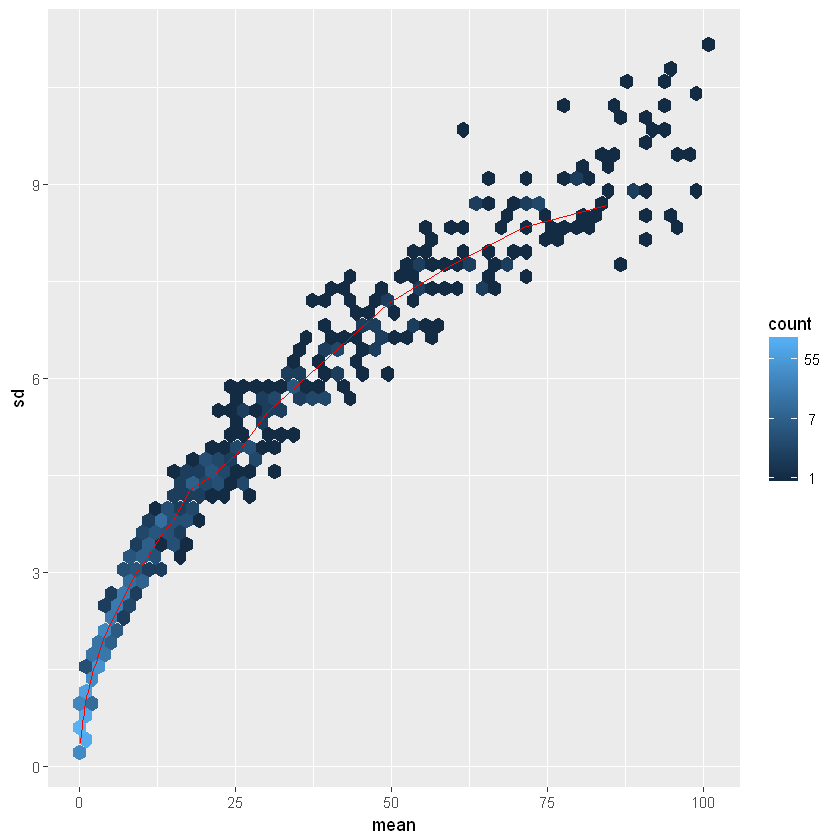

In [30]:
## ----meanSdCts-----------------------------------------------------------
lambda <- 10^seq(from = -1, to = 2, length = 1000)
cts <- matrix(rpois(1000*100, lambda), ncol = 100)
library("vsn")
meanSdPlot(cts, ranks = FALSE)


Logarithm-transformed counts:

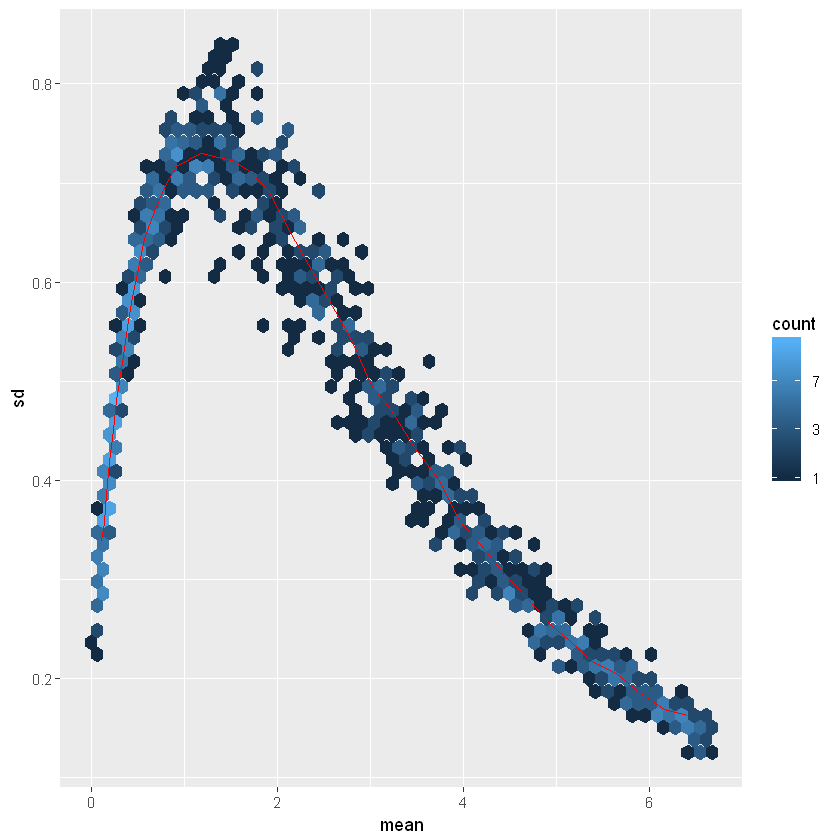

In [31]:
## ----meanSdLogCts--------------------------------------------------------
log.cts.one <- log2(cts + 1)
meanSdPlot(log.cts.one, ranks = FALSE)


The logarithm with a small pseudocount amplifies differences when the values are close to 0. The low count genes with low signal-to-noise ratio will overly contribute to sample-sample distances and PCA plots.

As a solution, DESeq2 offers two transformations for count data that stabilize the variance across the mean: the regularized-logarithm transformation or rlog (Love, Huber, and Anders 2014), and the variance stabilizing transformation (VST) for negative binomial data with a dispersion-mean trend (Anders and Huber 2010), implemented in the vst function.

For genes with high counts, the rlog and VST will give similar result to the ordinary log2 transformation of normalized counts. For genes with lower counts, however, the values are shrunken towards the genes’ averages across all samples. The rlog-transformed or VST data then becomes approximately homoskedastic, and can be used directly for computing distances between samples, making PCA plots, or as input to downstream methods which perform best with homoskedastic data.


**Which transformation to choose?** The rlog tends to work well on small datasets (n < 30), sometimes outperforming the VST when there is a large range of sequencing depth across samples (an order of magnitude difference). The VST is much faster to compute and is less sensitive to high count outliers than the rlog. We therefore recommend the VST for large datasets (hundreds of samples). You can perform both transformations and compare the meanSdPlot or PCA plots generated, as described below.

Note that the two transformations offered by DESeq2 are provided for applications other than differential testing. For differential testing we recommend the DESeq function applied to raw counts, as described later in this workflow, which also takes into account the dependence of the variance of counts on the mean value during the dispersion estimation step.

The function rlog returns an object based on the SummarizedExperiment class that contains the rlog-transformed values in its assay slot.

In [32]:
## ----rlog----------------------------------------------------------------
rld <- rlog(dds, blind = FALSE)
head(assay(rld), 3)

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
ENSG00000000003,9.385683,9.052608,9.516875,9.285338,9.839085,9.530311,9.663255,9.277699
ENSG00000000419,8.869616,9.138271,9.036116,9.075295,8.972126,9.131824,8.861534,9.060905
ENSG00000000457,7.961369,7.881385,7.824079,7.921490,7.751699,7.886441,7.957121,7.912123


The function *vst* returns a similar object

In [33]:
print("VST output:")
## ----vst-----------------------------------------------------------------
vsd <- vst(dds, blind = FALSE)
head(assay(vsd), 3)

[1] "VST output:"


,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
ENSG00000000003,9.742340,9.430742,9.867872,9.646127,10.183344,9.880660,10.010591,9.640065
ENSG00000000419,9.334009,9.582000,9.486456,9.523397,9.427605,9.575154,9.326341,9.509553
ENSG00000000457,8.765748,8.698941,8.651978,8.732909,8.593308,8.703164,8.762420,8.724586


In the above function calls, we specified blind = FALSE, which means that differences between cell lines and treatment (the variables in the design) will not contribute to the expected variance-mean trend of the experiment. The experimental design is not used directly in the transformation, only in estimating the global amount of variability in the counts. For a fully unsupervised transformation, one can set blind = TRUE (which is the default).

To show the effect of the transformation, in the figure below we plot the first sample against the second, first simply using the log2 function (after adding 1, to avoid taking the log of zero), and then using the rlog- and VST-transformed values. For the log2 approach, we need to first estimate size factors to account for sequencing depth, and then specify normalized=TRUE. Sequencing depth correction is done automatically for the rlog and the vst.

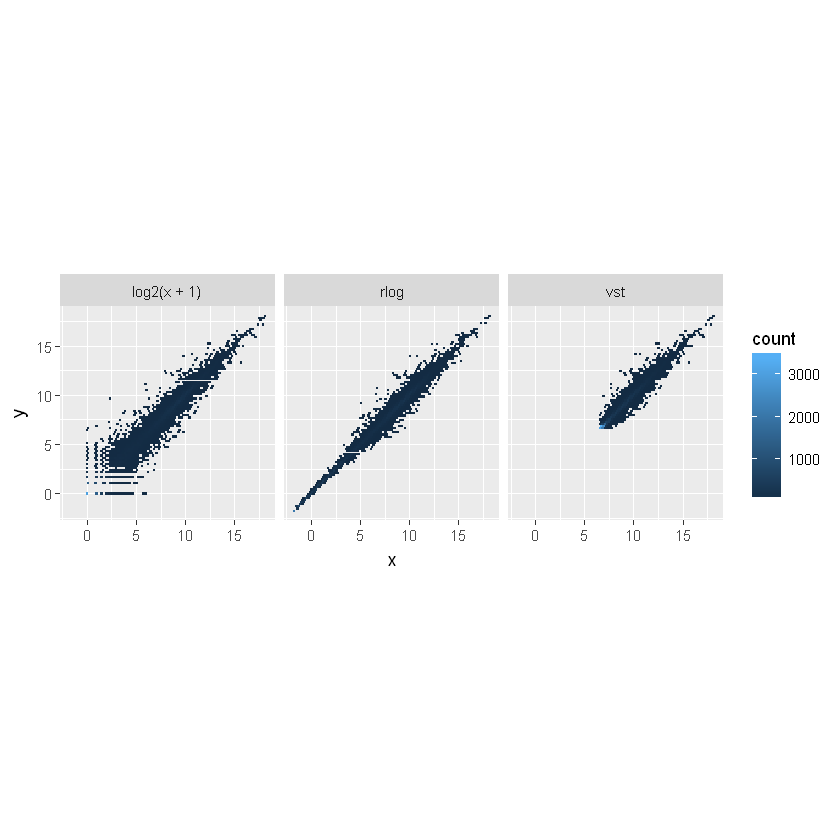

In [34]:
## ----rldplot, fig.width = 6, fig.height = 2.5----------------------------
suppressPackageStartupMessages(library("dplyr"))
suppressPackageStartupMessages(library("ggplot2"))

dds <- estimateSizeFactors(dds)

df <- bind_rows(
  as_data_frame(log2(counts(dds, normalized=TRUE)[, 1:2]+1)) %>%
         mutate(transformation = "log2(x + 1)"),
  as_data_frame(assay(rld)[, 1:2]) %>% mutate(transformation = "rlog"),
  as_data_frame(assay(vsd)[, 1:2]) %>% mutate(transformation = "vst"))
  
colnames(df)[1:2] <- c("x", "y")  

ggplot(df, aes(x = x, y = y)) + geom_hex(bins = 80) +
  coord_fixed() + facet_grid( . ~ transformation)  

**Scatterplot of transformed counts from two samples.** 
Shown are scatterplots using the log2 transform of normalized counts (left), using the rlog (middle), and using the VST (right). While the rlog is on roughly the same scale as the log2 counts, the VST has a upward shift for the smaller values. It is the differences between samples (deviation from y=x in these scatterplots) which will contribute to the distance calculations and the PCA plot.

We can see how genes with low counts (bottom left-hand corner) seem to be excessively variable on the ordinary logarithmic scale, while the rlog transform and VST compress differences for the low count genes for which the data provide little information about differential expression.

### Sample Distance

A useful first step in an RNA-seq analysis is often to assess overall similarity between samples: Which samples are similar to each other, which are different? Does this fit to the expectation from the experiment’s design?

We use the R function dist to calculate the Euclidean distance between samples. To ensure we have a roughly equal contribution from all genes, we use it on the rlog-transformed data. We need to transpose the matrix of values using t, because the dist function expects the different samples to be rows of its argument, and different dimensions (here, genes) to be columns.

In [35]:
## ------------------------------------------------------------------------
sampleDists <- dist(t(assay(rld)))
sampleDists

           SRR1039508 SRR1039509 SRR1039512 SRR1039513 SRR1039516 SRR1039517
SRR1039509   45.69859                                                       
SRR1039512   39.25239   54.90828                                            
SRR1039513   62.63201   44.52740   48.72579                                 
SRR1039516   44.50557   59.06364   43.57856   63.74275                      
SRR1039517   64.49410   51.44882   59.22962   49.87992   47.48200           
SRR1039520   39.57693   57.46259   36.74434   58.49014   46.40786   63.59942
SRR1039521   63.36124   45.05732   57.87616   36.49484   65.54600   52.31695
           SRR1039520
SRR1039509           
SRR1039512           
SRR1039513           
SRR1039516           
SRR1039517           
SRR1039520           
SRR1039521   50.13430

We visualize the distances in a heatmap in a figure below, using the function pheatmap from the pheatmap package.

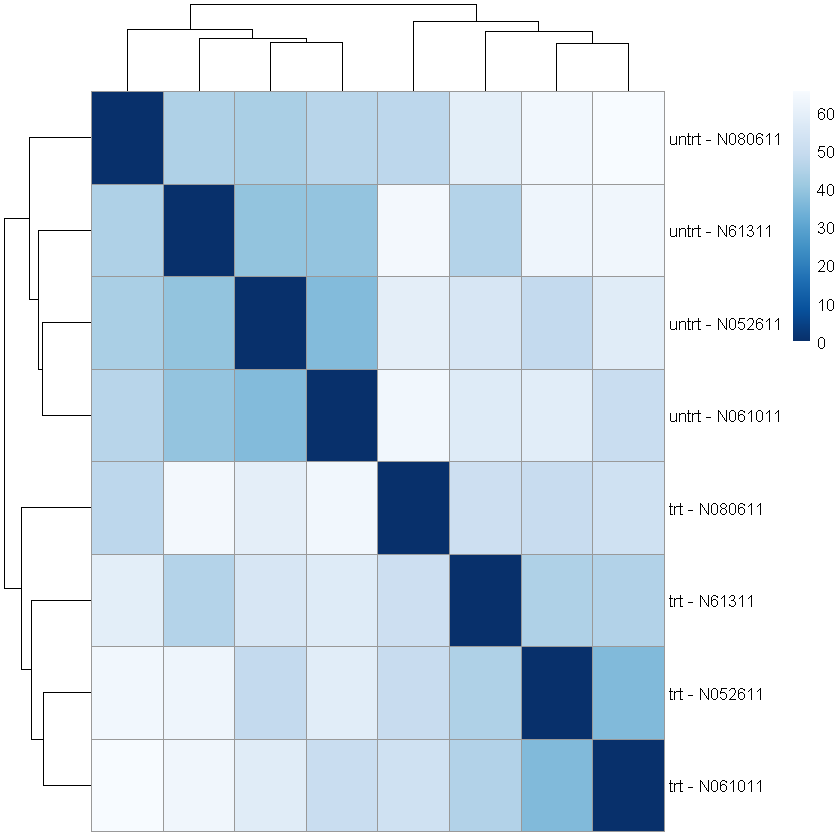

In [36]:
## ------------------------------------------------------------------------
library("pheatmap")
library("RColorBrewer")

## ----distheatmap, fig.width = 6.1, fig.height = 4.5----------------------
sampleDistMatrix <- as.matrix( sampleDists )
rownames(sampleDistMatrix) <- paste( rld$dex, rld$cell, sep = " - " )
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows = sampleDists,
         clustering_distance_cols = sampleDists,
         col = colors)

**Heatmap of sample-to-sample distances using the rlog-transformed values.**

Note that we have changed the row names of the distance matrix to contain treatment type and patient number instead of sample ID, so that we have all this information in view when looking at the heatmap.


Another option for calculating sample distances is to use the Poisson Distance (Witten 2011), implemented in the PoiClaClu package. This measure of dissimilarity between counts also takes the inherent variance structure of counts into consideration when calculating the distances between samples. The PoissonDistance function takes the original count matrix (not normalized) with samples as rows instead of columns, so we need to transpose the counts in dds.

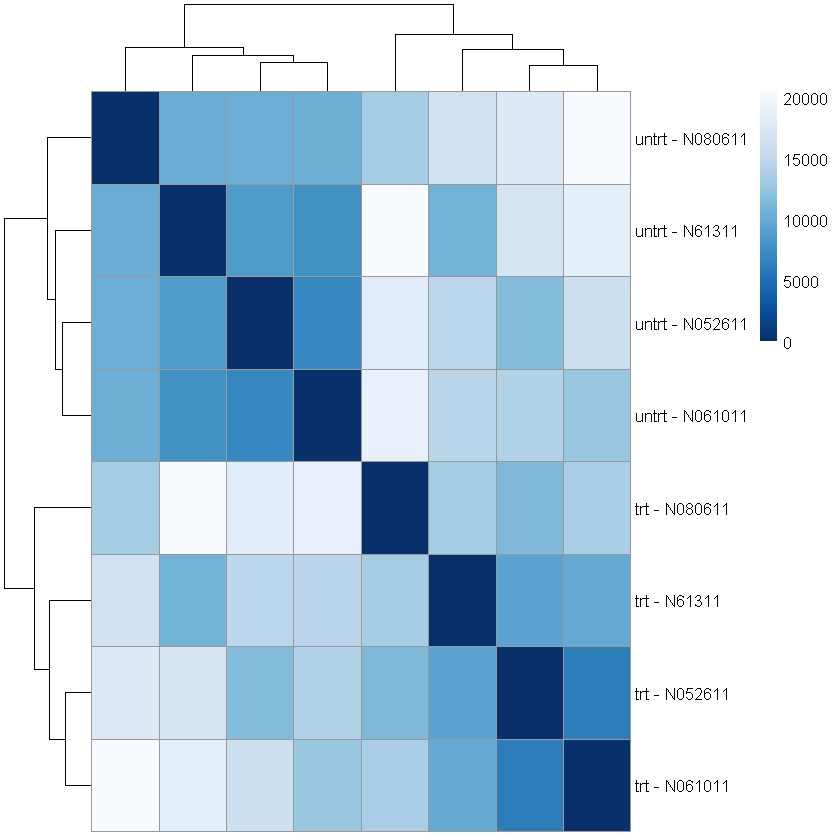

In [37]:
## ------------------------------------------------------------------------
library("PoiClaClu")
poisd <- PoissonDistance(t(counts(dds)))

## ----poisdistheatmap, fig.width = 6.1, fig.height = 4.5------------------
samplePoisDistMatrix <- as.matrix( poisd$dd )
rownames(samplePoisDistMatrix) <- paste( rld$dex, rld$cell, sep=" - " )
colnames(samplePoisDistMatrix) <- NULL
pheatmap(samplePoisDistMatrix,
         clustering_distance_rows = poisd$dd,
         clustering_distance_cols = poisd$dd,
         col = colors)


**Heatmap of sample-to-sample distances using the Poisson Distance.**

### PCA plot

Another way to visualize sample-to-sample distances is a principal components analysis (PCA). In this ordination method, the data points (here, the samples) are projected onto the 2D plane such that they spread out in the two directions that explain most of the differences (figure below). The x-axis is the direction that separates the data points the most. The values of the samples in this direction are written PC1. The y-axis is a direction (it must be orthogonal to the first direction) that separates the data the second most. The values of the samples in this direction are written PC2. The percent of the total variance that is contained in the direction is printed in the axis label. Note that these percentages do not add to 100%, because there are more dimensions that contain the remaining variance (although each of these remaining dimensions will explain less than the two that we see).

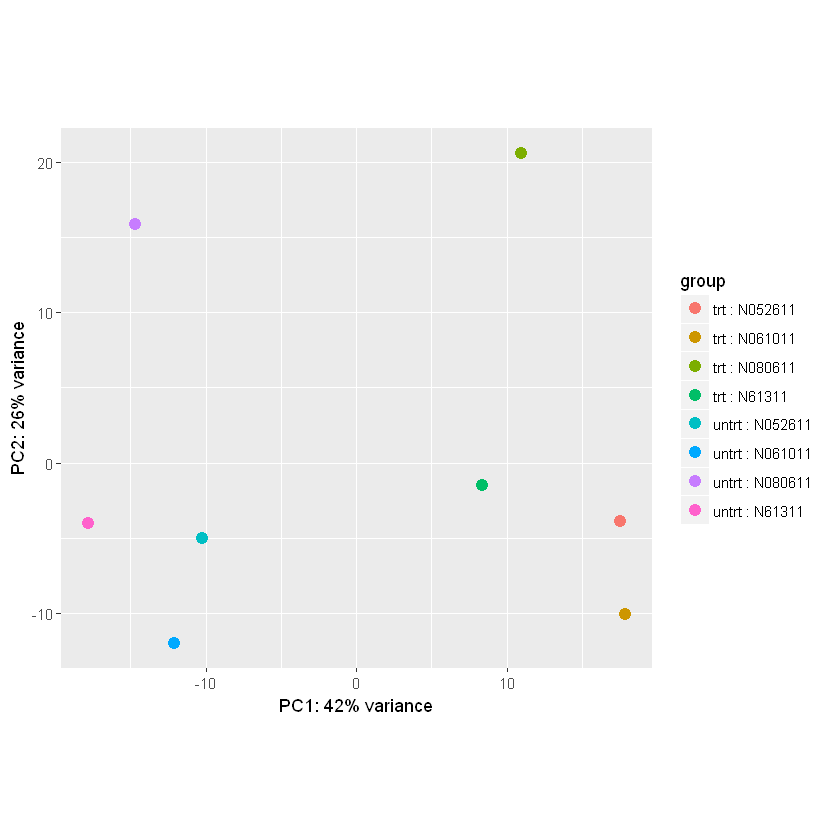

In [38]:
## ----plotpca, fig.width=6, fig.height=4.5--------------------------------
plotPCA(rld, intgroup = c("dex", "cell"))


**PCA plot using the rlog-transformed values.** Each unique combination of treatment and cell line is given its own color.

Here, we have used the function plotPCA that comes with DESeq2 [8]. The two terms specified by intgroup are the interesting groups for labeling the samples; they tell the function to use them to choose colors. We can also build the PCA plot from scratch using the ggplot2 package (Wickham 2009). This is done by asking the plotPCA function to return the data used for plotting rather than building the plot. See the ggplot2 documentation for more details on using ggplot.

,PC1,PC2,group,dex,cell,name
SRR1039508,-17.81773,-4.020836,untrt : N61311,untrt,N61311,SRR1039508
SRR1039509,8.38790,-1.490805,trt : N61311,trt,N61311,SRR1039509
SRR1039512,-10.22735,-5.004069,untrt : N052611,untrt,N052611,SRR1039512
SRR1039513,17.53277,-3.909890,trt : N052611,trt,N052611,SRR1039513
SRR1039516,-14.67169,15.873239,untrt : N080611,untrt,N080611,SRR1039516
SRR1039517,10.98782,20.598625,trt : N080611,trt,N080611,SRR1039517
SRR1039520,-12.06035,-11.985876,untrt : N061011,untrt,N061011,SRR1039520
SRR1039521,17.86863,-10.060389,trt : N061011,trt,N061011,SRR1039521


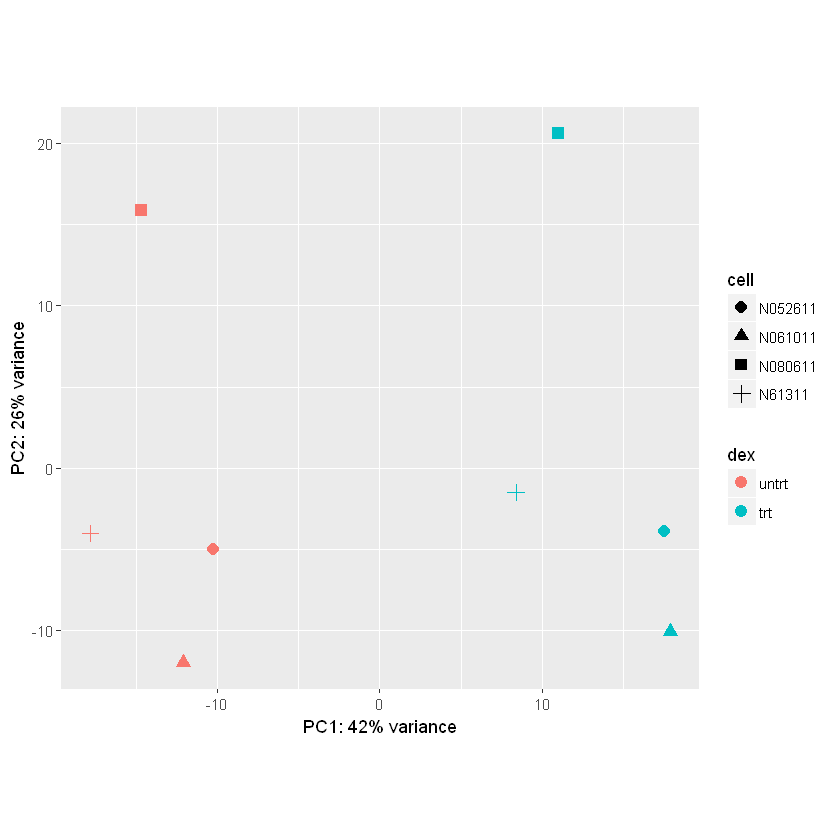

In [39]:
## ------------------------------------------------------------------------
pcaData <- plotPCA(rld, intgroup = c( "dex", "cell"), returnData = TRUE)
pcaData
percentVar <- round(100 * attr(pcaData, "percentVar"))

## ----ggplotpca, fig.width=6, fig.height=4.5------------------------------
ggplot(pcaData, aes(x = PC1, y = PC2, color = dex, shape = cell)) +
  geom_point(size =3) +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  coord_fixed()


**PCA plot using the rlog-transformed values with custom ggplot2 code.** Here we specify cell line (plotting symbol) and dexamethasone treatment (color).

From the PCA plot, we see that the differences between cells (the different plotting shapes) are considerable, though not stronger than the differences due to treatment with dexamethasone (red vs blue color). This shows why it will be important to account for this in differential testing by using a paired design (“paired”, because each dex treated sample is paired with one untreated sample from the same cell line). We are already set up for this design by assigning the formula ~ cell + dex earlier.

### MDS plot

Another plot, very similar to the PCA plot, can be made using the multidimensional scaling (MDS) function in base R. This is useful when we don’t have a matrix of data, but only a matrix of distances. Here we compute the MDS for the distances calculated from the rlog transformed counts and plot these in a figure below.

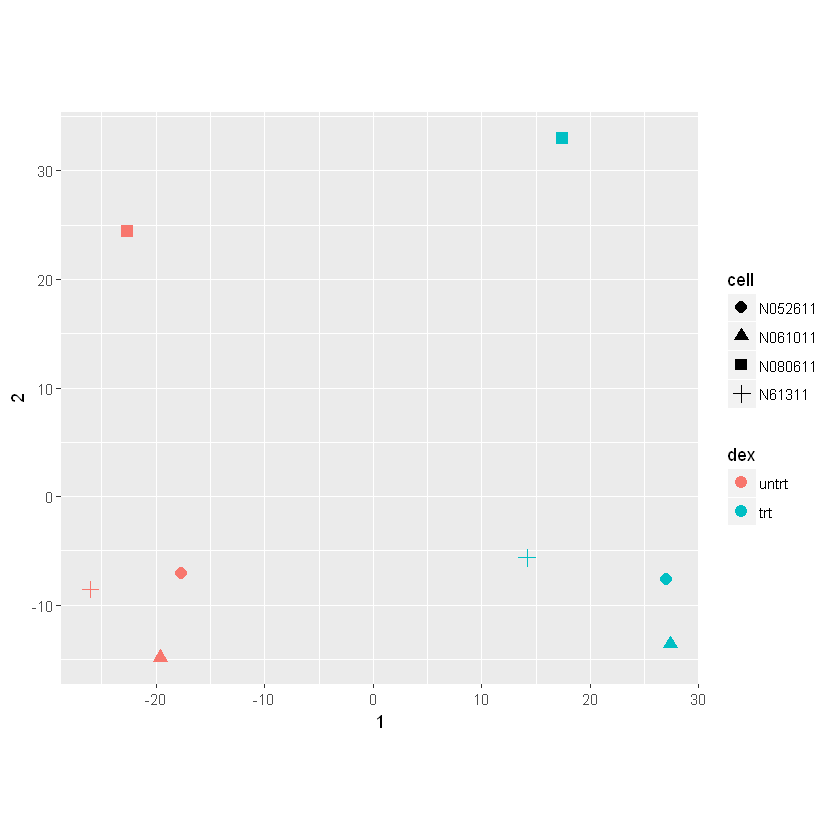

In [40]:
## ----mdsrlog, fig.width=6, fig.height=4.5--------------------------------
mds <- as.data.frame(colData(rld))  %>%
         cbind(cmdscale(sampleDistMatrix))
ggplot(mds, aes(x = `1`, y = `2`, color = dex, shape = cell)) +
  geom_point(size = 3) + coord_fixed()


#### MDS plot using rlog-transformed vlaues.

In a figure below we show the same plot for the PoissonDistance:

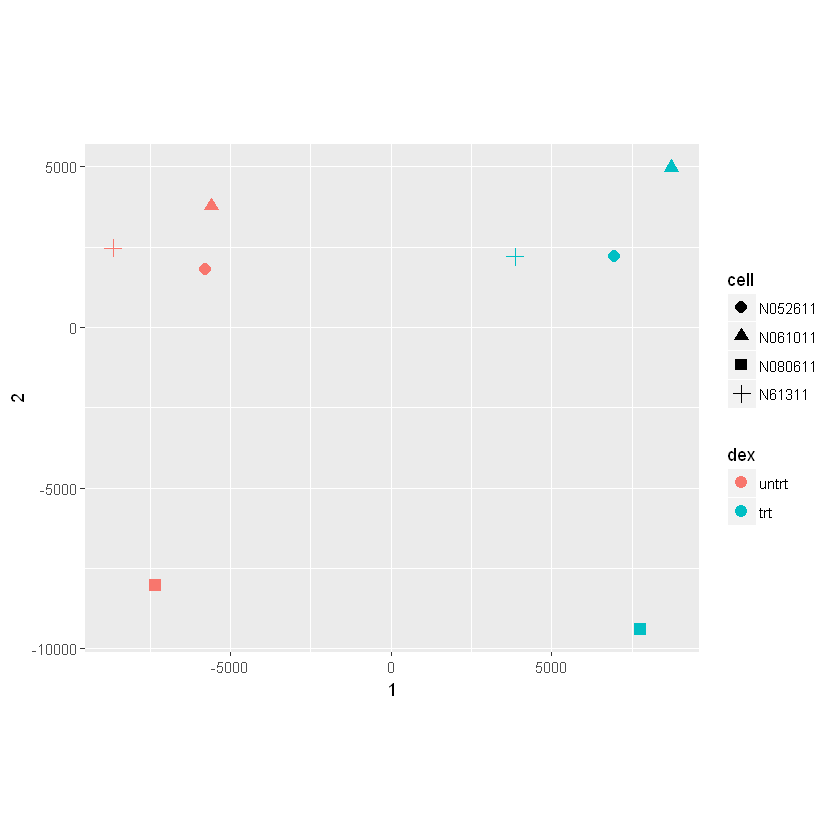

In [41]:

## ----mdspois, fig.width=6, fig.height=4.5--------------------------------
mdsPois <- as.data.frame(colData(dds)) %>%
   cbind(cmdscale(samplePoisDistMatrix))
ggplot(mdsPois, aes(x = `1`, y = `2`, color = dex, shape = cell)) +
  geom_point(size = 3) + coord_fixed()


**MDS plot using the *Poisson Distance* **

## Differentital expression analysis

### Running the differential expression pipeline

As we have already specified an experimental design when we created the DESeqDataSet, we can run the differential expression pipeline on the raw counts with a single call to the function DESeq:

In [42]:
dds <- DESeq(dds)

using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


This function will print out a message for the various steps it performs. These are described in more detail in the manual page for DESeq, which can be accessed by typing ?DESeq. Briefly these are: the estimation of size factors (controlling for differences in the sequencing depth of the samples), the estimation of dispersion values for each gene, and fitting a generalized linear model.

A DESeqDataSet is returned that contains all the fitted parameters within it, and the following section describes how to extract out results tables of interest from this object.

### Building the results table

Calling results without any arguments will extract the estimated log2 fold changes and p values for the last variable in the design formula. If there are more than 2 levels for this variable, results will extract the results table for a comparison of the last level over the first level. The comparison is printed at the top of the output: dex trt vs untrt.

In [43]:
res <- results(dds)
res

mcols(res, use.names = TRUE)


log2 fold change (MAP): dex trt vs untrt 
Wald test p-value: dex trt vs untrt 
DataFrame with 29391 rows and 6 columns
                   baseMean log2FoldChange      lfcSE       stat      pvalue
                  <numeric>      <numeric>  <numeric>  <numeric>   <numeric>
ENSG00000000003 708.6021697    -0.37415193 0.09884432 -3.7852648 0.000153545
ENSG00000000419 520.2979006     0.20206144 0.10974240  1.8412340 0.065587276
ENSG00000000457 237.1630368     0.03616620 0.13834538  0.2614196 0.793768939
ENSG00000000460  57.9326331    -0.08446385 0.24990676 -0.3379815 0.735377161
ENSG00000000938   0.3180984    -0.08413904 0.15133427 -0.5559814 0.578223585
...                     ...            ...        ...        ...         ...
ENSG00000273485   1.2864477     0.03398815  0.2932360  0.1159071   0.9077261
ENSG00000273486  15.4525365    -0.09560732  0.3410333 -0.2803460   0.7792120
ENSG00000273487   8.1632350     0.55007412  0.3725061  1.4766847   0.1397602
ENSG00000273488   8.5844790     0.

DataFrame with 6 rows and 2 columns
                       type                               description
                <character>                               <character>
baseMean       intermediate mean of normalized counts for all samples
log2FoldChange      results  log2 fold change (MAP): dex trt vs untrt
lfcSE               results          standard error: dex trt vs untrt
stat                results          Wald statistic: dex trt vs untrt
pvalue              results       Wald test p-value: dex trt vs untrt
padj                results                      BH adjusted p-values

The first column, baseMean, is a just the average of the normalized count values, divided by the size factors, taken over all samples in the DESeqDataSet. The remaining four columns refer to a specific contrast, namely the comparison of the trt level over the untrt level for the factor variable dex. We will find out below how to obtain other contrasts.

The column log2FoldChange is the effect size estimate. It tells us how much the gene’s expression seems to have changed due to treatment with dexamethasone in comparison to untreated samples. This value is reported on a logarithmic scale to base 2: for example, a log2 fold change of 1.5 means that the gene’s expression is increased by a multiplicative factor of 21.5 ≈ 2.82.

Of course, this estimate has an uncertainty associated with it, which is available in the column lfcSE, the standard error estimate for the log2 fold change estimate. We can also express the uncertainty of a particular effect size estimate as the result of a statistical test. The purpose of a test for differential expression is to test whether the data provides sufficient evidence to conclude that this value is really different from zero. DESeq2 [8] performs for each gene a hypothesis test to see whether evidence is sufficient to decide against the null hypothesis that there is zero effect of the treatment on the gene and that the observed difference between treatment and control was merely caused by experimental variability (i.e., the type of variability that you can expect between different samples in the same treatment group). As usual in statistics, the result of this test is reported as a p value, and it is found in the column pvalue. Remember that a p value indicates the probability that a fold change as strong as the observed one, or even stronger, would be seen under the situation described by the null hypothesis.


We can also summarize the results with the following line of code, which reports some additional information, that will be covered in later sections.

In [44]:
summary(res)


out of 29391 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 2617, 8.9% 
LFC < 0 (down)   : 2204, 7.5% 
outliers [1]     : 0, 0% 
low counts [2]   : 11397, 39% 
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Note that there are many genes with differential expression due to dexamethasone treatment at the FDR level of 10%. This makes sense, as the smooth muscle cells of the airway[2] are known to react to glucocorticoid steroids. However, there are two ways to be more strict about which set of genes are considered significant:

* lower the false discovery rate threshold (the threshold on padj in the results table)
* raise the log2 fold change threshold from 0 using the lfcThreshold argument of results

If we lower the false discovery rate threshold, we should also inform the results() function about it, so that the function can use this threshold for the optimal independent filtering that it performs:

In [45]:
## ------------------------------------------------------------------------
res.05 <- results(dds, alpha = 0.05)
table(res.05$padj < 0.05)



FALSE  TRUE 
12841  4014 

If we want to raise the log2 fold change threshold, so that we test for genes that show more substantial changes due to treatment, we simply supply a value on the log2 scale. For example, by specifying lfcThreshold = 1, we test for genes that show significant effects of treatment on gene counts more than doubling or less than halving, because 21 = 2.

In [46]:
## ------------------------------------------------------------------------
resLFC1 <- results(dds, lfcThreshold=1)
table(resLFC1$padj < 0.1)



FALSE  TRUE 
18368   196 

Sometimes a subset of the p values in res will be NA (“not available”). This is DESeq’s way of reporting that all counts for this gene were zero, and hence no test was applied. In addition, p values can be assigned NA if the gene was excluded from analysis because it contained an extreme count outlier. For more information, see the outlier detection section of the DESeq2 [8] vignette.

If you use the results from an R analysis package in published research, you can find the proper citation for the software by typing citation("pkgName"), where you would substitute the name of the package for pkgName. Citing methods papers helps to support and reward the individuals who put time into open source software for genomic data analysis.

### Other comaprisions

In general, the results for a comparison of any two levels of a variable can be extracted using the contrast argument to results. The user should specify three values: the name of the variable, the name of the level for the numerator, and the name of the level for the denominator. Here we extract results for the log2 of the fold change of one cell line over another:

In [47]:
results(dds, contrast = c("cell", "N061011", "N61311"))

log2 fold change (MAP): cell N061011 vs N61311 
Wald test p-value: cell N061011 vs N61311 
DataFrame with 29391 rows and 6 columns
                   baseMean log2FoldChange      lfcSE         stat     pvalue
                  <numeric>      <numeric>  <numeric>    <numeric>  <numeric>
ENSG00000000003 708.6021697     0.29015273 0.13600619    2.1333788 0.03289366
ENSG00000000419 520.2979006    -0.05059433 0.14952670   -0.3383632 0.73508951
ENSG00000000457 237.1630368     0.01470174 0.18299791    0.0803383 0.93596820
ENSG00000000460  57.9326331     0.19881498 0.28110398    0.7072649 0.47940186
ENSG00000000938   0.3180984     0.00000000 0.07395438    0.0000000 1.00000000
...                     ...            ...        ...          ...        ...
ENSG00000273485   1.2864477   -0.170393536 0.15852221 -1.074887456  0.2824251
ENSG00000273486  15.4525365   -0.028818343 0.30362829 -0.094913237  0.9243837
ENSG00000273487   8.1632350   -0.001849525 0.27408559 -0.006747984  0.9946159
ENSG0000027

If results for an interaction term are desired, the name argument of results should be used. Please see the help for the results function for more details.

### Multiple testing

In high-throughput biology, we are careful to not use the p values directly as evidence against the null, but to correct for multiple testing. What would happen if we were to simply threshold the p values at a low value, say 0.05? There are 5676 genes with a p value below 0.05 among the 29391 genes for which the test succeeded in reporting a p value:

In [48]:
## ----sumres--------------------------------------------------------------
sum(res$pvalue < 0.05, na.rm=TRUE)
sum(!is.na(res$pvalue))

[1] 5648

[1] 29391

Now, assume for a moment that the null hypothesis is true for all genes, i.e., no gene is affected by the treatment with dexamethasone. Then, by the definition of the p value, we expect up to 5% of the genes to have a p value below 0.05. This amounts to 1470 genes. If we just considered the list of genes with a p value below 0.05 as differentially expressed, this list should therefore be expected to contain up to 1470 / 5676 = 26% false positives.

DESeq2 [8] uses the Benjamini-Hochberg (BH) adjustment (Benjamini and Hochberg 1995) as implemented in the base R p.adjust function; in brief, this method calculates for each gene an adjusted p value that answers the following question: if one called significant all genes with an adjusted p value less than or equal to this gene’s adjusted p value threshold, what would be the fraction of false positives (the false discovery rate, FDR) among them, in the sense of the calculation outlined above? These values, called the BH-adjusted p values, are given in the column padj of the res object.
The FDR is a useful statistic for many high-throughput experiments, as we are often interested in reporting or focusing on a set of interesting genes, and we would like to put an upper bound on the percent of false positives in this set.

Hence, if we consider a fraction of 10% false positives acceptable, we can consider all genes with an adjusted p value below 10% = 0.1 as significant. How many such genes are there?

In [49]:
sum(res$padj < 0.1, na.rm=TRUE)

[1] 4821

We subset the results table to these genes and then sort it by the log2 fold change estimate to get the significant genes with the strongest down-regulation:

In [50]:
resSig <- subset(res, padj < 0.1)
head(resSig[ order(resSig$log2FoldChange), ])


log2 fold change (MAP): dex trt vs untrt 
Wald test p-value: dex trt vs untrt 
DataFrame with 6 rows and 6 columns
                 baseMean log2FoldChange     lfcSE       stat       pvalue
                <numeric>      <numeric> <numeric>  <numeric>    <numeric>
ENSG00000162692 508.17023      -3.449451 0.1767133 -19.520040 7.418019e-85
ENSG00000105989 333.21469      -2.847367 0.1763077 -16.149989 1.135822e-58
ENSG00000146006  46.80760      -2.828103 0.3377002  -8.374596 5.541346e-17
ENSG00000214814 243.27698      -2.753580 0.2235524 -12.317379 7.302919e-35
ENSG00000267339  26.23357      -2.704529 0.3519704  -7.683967 1.542363e-14
ENSG00000013293 244.49733      -2.641033 0.1992865 -13.252442 4.367569e-40
                        padj
                   <numeric>
ENSG00000162692 9.534273e-82
ENSG00000105989 5.839423e-56
ENSG00000146006 2.702195e-15
ENSG00000214814 1.228119e-32
ENSG00000267339 5.904954e-13
ENSG00000013293 8.830342e-38

And the strongest up-regulation:

In [51]:
## ------------------------------------------------------------------------
head(resSig[ order(resSig$log2FoldChange, decreasing = TRUE), ])

log2 fold change (MAP): dex trt vs untrt 
Wald test p-value: dex trt vs untrt 
DataFrame with 6 rows and 6 columns
                 baseMean log2FoldChange     lfcSE      stat        pvalue
                <numeric>      <numeric> <numeric> <numeric>     <numeric>
ENSG00000109906 385.07103       4.847146 0.3313650  14.62781  1.866877e-48
ENSG00000179593  67.24305       4.830826 0.3314188  14.57620  3.980821e-48
ENSG00000152583 997.43977       4.313968 0.1721375  25.06117 1.319002e-138
ENSG00000163884 561.10717       4.074334 0.2104702  19.35824  1.737077e-83
ENSG00000250978  56.31819       4.054730 0.3294741  12.30667  8.339021e-35
ENSG00000168309 159.52692       3.977125 0.2558468  15.54495  1.721597e-54
                         padj
                    <numeric>
ENSG00000109906  5.893437e-46
ENSG00000179593  1.193848e-45
ENSG00000152583 2.373412e-134
ENSG00000163884  1.953560e-80
ENSG00000250978  1.389373e-32
ENSG00000168309  7.744606e-52

## Plotting Results

A quick way to visualize the counts for a particular gene is to use the plotCounts function that takes as arguments the DESeqDataSet, a gene name, and the group over which to plot the counts (figure below).

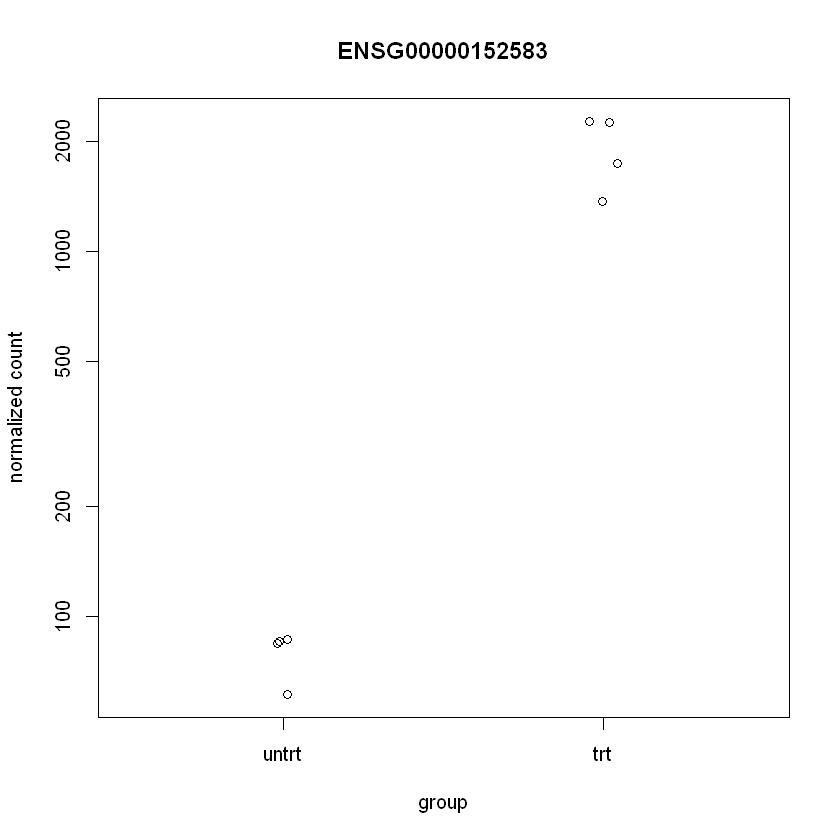

In [52]:
## ----plotcounts----------------------------------------------------------
topGene <- rownames(res)[which.min(res$padj)]
plotCounts(dds, gene = topGene, intgroup=c("dex"))

**Normalized counts for a single gene over treatment group.**

We can also make custom plots using the ggplot function from the ggplot2 package (figures below).

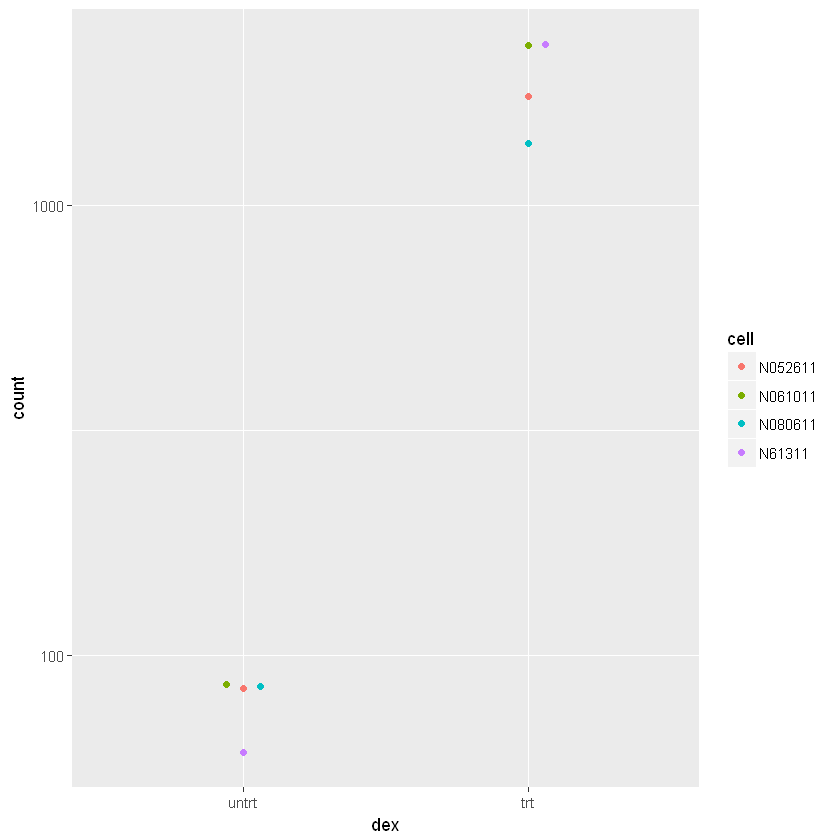

In [54]:
library("ggbeeswarm")
geneCounts <- plotCounts(dds, gene = topGene, intgroup = c("dex","cell"),
                         returnData = TRUE)
ggplot(geneCounts, aes(x = dex, y = count, color = cell)) +
  scale_y_log10() +  geom_beeswarm(cex = 3)

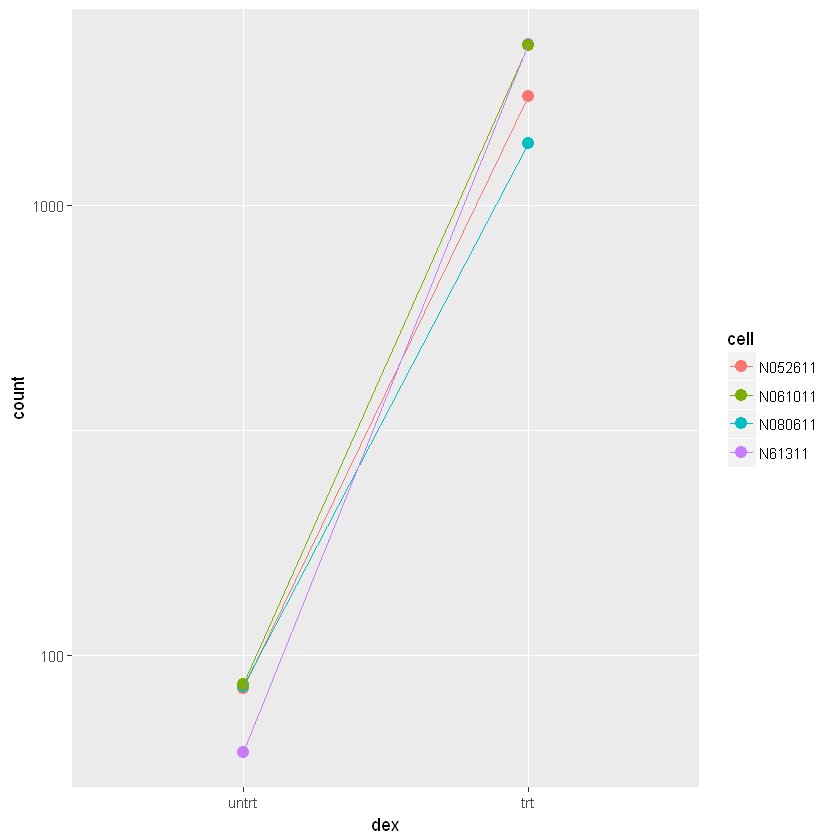

In [55]:
## ----ggplotcountsgroup, fig.width = 4, fig.height = 3--------------------
ggplot(geneCounts, aes(x = dex, y = count, color = cell, group = cell)) +
  scale_y_log10() + geom_point(size = 3) + geom_line()


**Normalized counts with lines connecting cell lines.**
Note that the DESeq test actually takes into account the cell line effect, so this figure more closely depicts the difference being tested.

An MA-plot (R. Dudoit et al. 2002) provides a useful overview for an experiment with a two-group comparison (figure below).

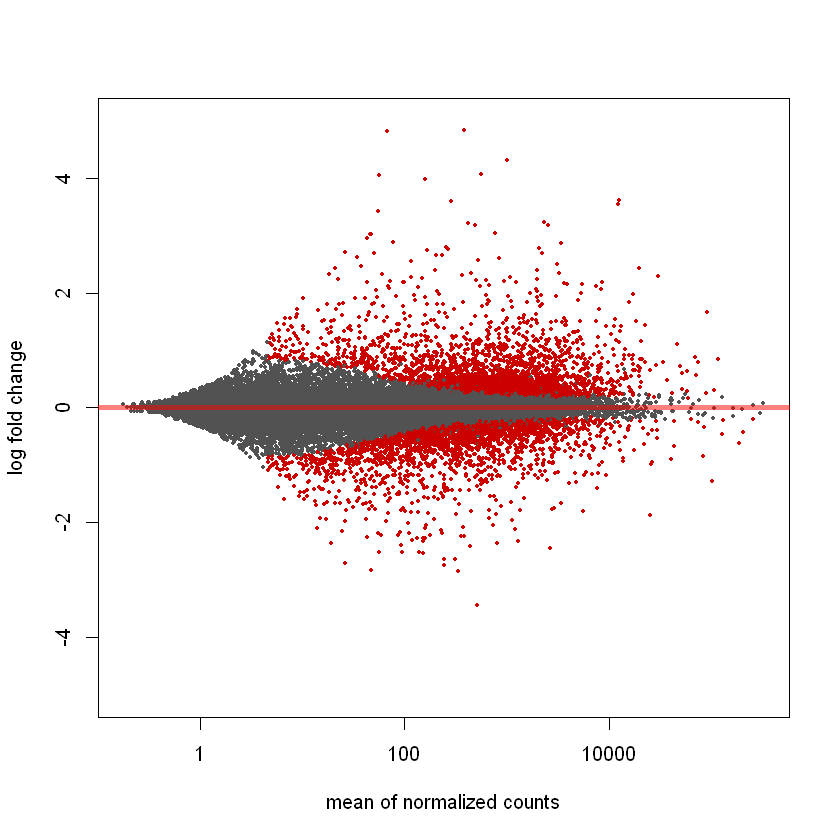

In [56]:
## ----plotma--------------------------------------------------------------
plotMA(res, ylim = c(-5, 5))

**An MA-plot of changes induced by treatment.** 
The log2 fold change for a particular comparison is plotted on the y-axis and the average of the counts normalized by size factor is shown on the x-axis (“M” for minus, because a log ratio is equal to log minus log, and “A” for average). Each gene is represented with a dot. Genes with an adjusted p value below a threshold (here 0.1, the default) are shown in red.

The DESeq2 [8] package uses statistical techniques to moderate log2 fold changes from genes with very low counts and highly variable counts, as can be seen by the narrowing of the vertical spread of points on the left side of the MA-plot. For a detailed explanation of the rationale of moderated fold changes, please see the DESeq2 [8] paper (Love, Huber, and Anders 2014). This plot demonstrates that only genes with a large average normalized count contain sufficient information to yield a significant call.

We can also make an MA-plot for the results table in which we raised the log2 fold change threshold (figure below). We can label individual points on the MA-plot as well. Here we use the with R function to plot a circle and text for a selected row of the results object. Within the with function, only the baseMean and log2FoldChange values for the selected rows of res are used.

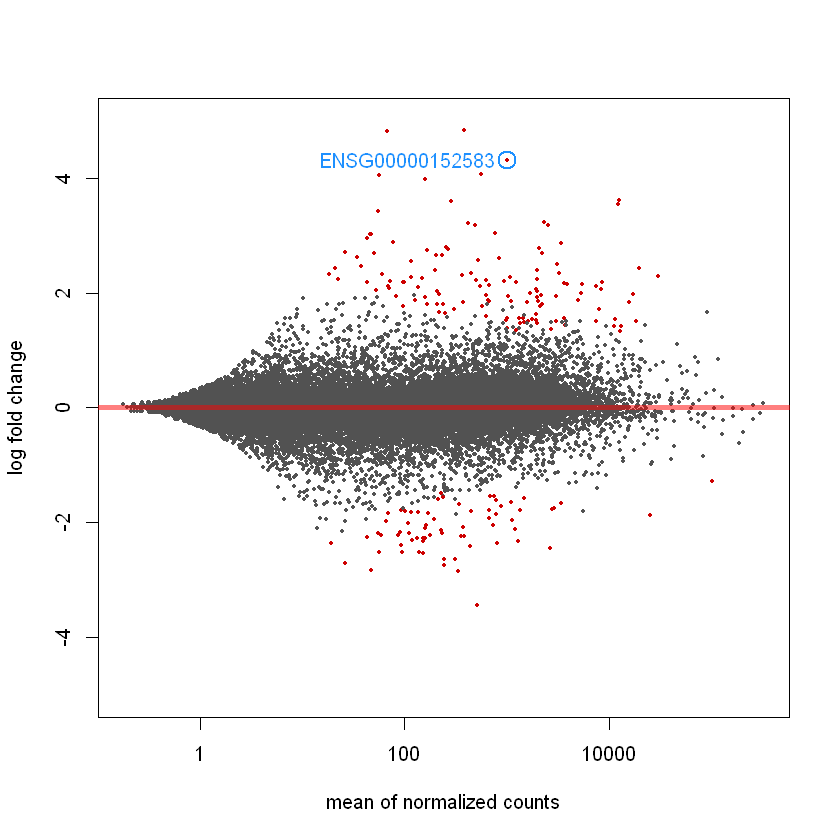

In [57]:
## ----plotmalabel---------------------------------------------------------
plotMA(resLFC1, ylim = c(-5,5))
topGene <- rownames(resLFC1)[which.min(resLFC1$padj)]
with(resLFC1[topGene, ], {
  points(baseMean, log2FoldChange, col="dodgerblue", cex=2, lwd=2)
  text(baseMean, log2FoldChange, topGene, pos=2, col="dodgerblue")
})

**An MA-plot of a test for large log2 fold changes.** The red points indicate genes for which the log2 fold change was significantly higher than 1 or less than -1 (treatment resulting in more than doubling or less than halving of the normalized counts). The point circled in blue indicates the gene with the lowest adjusted p value.

Another useful diagnostic plot is the histogram of the p values (figure below). This plot is best formed by excluding genes with very small counts, which otherwise generate spikes in the histogram.

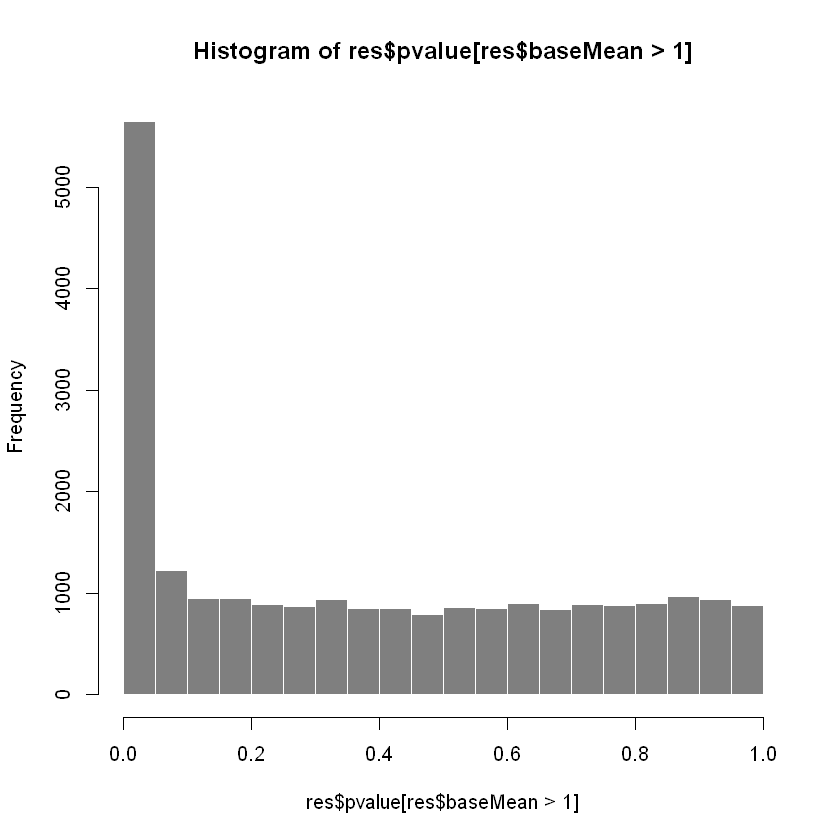

In [58]:
hist(res$pvalue[res$baseMean > 1], breaks = 0:20/20,
     col = "grey50", border = "white")

**Histogram of p values for genes with mean normalized count larger than 1.**

### Gene clustering

In the sample distance heatmap made previously, the dendrogram at the side shows us a hierarchical clustering of the samples. Such a clustering can also be performed for the genes. Since the clustering is only relevant for genes that actually carry a signal, one usually would only cluster a subset of the most highly variable genes. Here, for demonstration, let us select the 20 genes with the highest variance across samples. We will work with the rlog transformed counts:


In [59]:
library("genefilter")
topVarGenes <- head(order(rowVars(assay(rld)), decreasing = TRUE), 20)

The heatmap becomes more interesting if we do not look at absolute expression strength but rather at the amount by which each gene deviates in a specific sample from the gene’s average across all samples. Hence, we center each genes’ values across samples, and plot a heatmap (figure below). We provide a data.frame that instructs the pheatmap function how to label the columns.

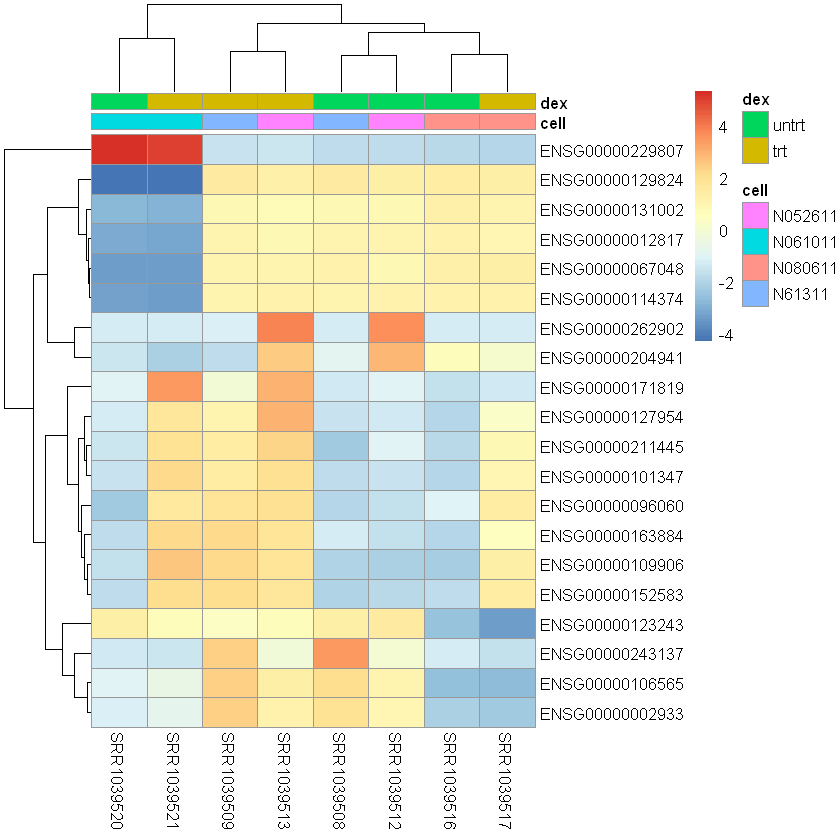

In [60]:
mat  <- assay(rld)[ topVarGenes, ]
mat  <- mat - rowMeans(mat)
anno <- as.data.frame(colData(rld)[, c("cell","dex")])
pheatmap(mat, annotation_col = anno)

**Heatmap of relative rlog-transformed values across samples.** 
Treatment status and cell line information are shown with colored bars at the top of the heatmap. Blocks of genes that covary across patients. Note that a set of genes at the top of the heatmap are separating the N061011 cell line from the others. In the center of the heatmap, we see a set of genes for which the dexamethasone treated samples have higher gene expression.

**Independent Filtering**

The MA plot highlights an important property of RNA-seq data. For weakly expressed genes, we have no chance of seeing differential expression, because the low read counts suffer from such high Poisson noise that any biological effect is drowned in the uncertainties from the sampling at a low rate. We can also show this by examining the ratio of small p values (say, less than 0.05) for genes binned by mean normalized count. We will use the results table subjected to the threshold to show what this looks like in a case when there are few tests with small p value.

In the following code chunk, we create bins using the quantile function, bin the genes by base mean using cut, rename the levels of the bins using the middle point, calculate the ratio of p values less than 0.05 for each bin, and finally plot these ratios (figure below).

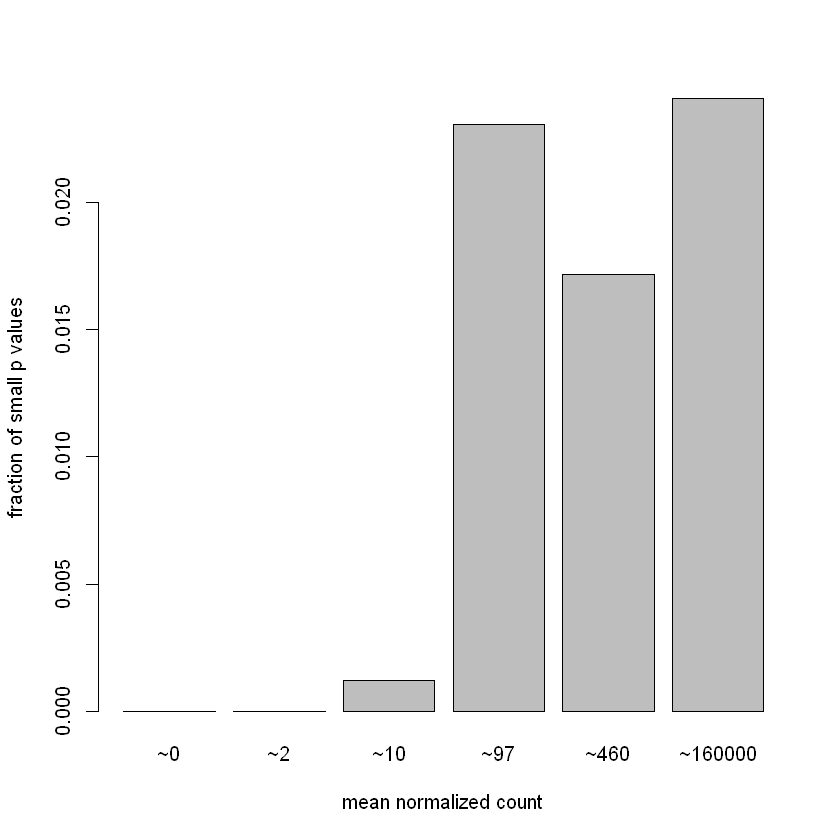

In [61]:
## ----sensitivityovermean, fig.width=6------------------------------------
qs <- c(0, quantile(resLFC1$baseMean[resLFC1$baseMean > 0], 0:6/6))
bins <- cut(resLFC1$baseMean, qs)
levels(bins) <- paste0("~", round(signif((qs[-1] + qs[-length(qs)])/2, 2)))
fractionSig <- tapply(resLFC1$pvalue, bins, function(p)
                          mean(p < .05, na.rm = TRUE))
barplot(fractionSig, xlab = "mean normalized count",
                     ylab = "fraction of small p values")

The ratio of small p values for genes binned by mean normalized count. The p values are from a test of log2 fold change greater than 1 or less than -1. This plot demonstrates that genes with very low mean count have little or no power, and are best excluded from testing.

At first sight, there may seem to be little benefit in filtering out these genes. After all, the test found them to be non-significant anyway. However, these genes have an influence on the multiple testing adjustment, whose performance improves if such genes are removed. By removing the low count genes from the input to the FDR procedure, we can find more genes to be significant among those that we keep, and so improved the power of our test. This approach is known as independent filtering.

The DESeq2 [8] software automatically performs independent filtering that maximizes the number of genes with adjusted p value less than a critical value (by default, alpha is set to 0.1). This automatic independent filtering is performed by, and can be controlled by, the results function.

The term independent highlights an important caveat. Such filtering is permissible only if the statistic that we filter on (here the mean of normalized counts across all samples) is independent of the actual test statistic (the p value) under the null hypothesis. Otherwise, the filtering would invalidate the test and consequently the assumptions of the BH procedure. The independent filtering software used inside DESeq2 [8] comes from the GeneFilter[10] package, that contains a reference to a paper describing the statistical foundation for independent filtering (Bourgon, Gentleman, and Huber 2010).

## Annotating and exporting results

Our result table so far only contains the Ensembl gene IDs, but alternative gene names may be more informative for interpretation. Bioconductor’s annotation packages help with mapping various ID schemes to each other. We load the AnnotationDbi [11] package and the annotation package org.Hs.eg.db:

In [62]:
## ------------------------------------------------------------------------
library("AnnotationDbi")
library("org.Hs.eg.db")

This is the organism annotation package (“org”) for Homo sapiens (“Hs”), organized as an AnnotationDbi [11] database package (“db”), using Entrez Gene IDs (“eg”) as primary key. To get a list of all available key types, use

In [63]:
## ------------------------------------------------------------------------
columns(org.Hs.eg.db)

[1] "ACCNUM"       "ALIAS"        "ENSEMBL"      "ENSEMBLPROT"  "ENSEMBLTRANS"
 [6] "ENTREZID"     "ENZYME"       "EVIDENCE"     "EVIDENCEALL"  "GENENAME"    
[11] "GO"           "GOALL"        "IPI"          "MAP"          "OMIM"        
[16] "ONTOLOGY"     "ONTOLOGYALL"  "PATH"         "PFAM"         "PMID"        
[21] "PROSITE"      "REFSEQ"       "SYMBOL"       "UCSCKG"       "UNIGENE"     
[26] "UNIPROT"

We can use the mapIds function to add individual columns to our results table. We provide the row names of our results table as a key, and specify that keytype=ENSEMBL. The column argument tells the mapIds function which information we want, and the multiVals argument tells the function what to do if there are multiple possible values for a single input value. Here we ask to just give us back the first one that occurs in the database. To add the gene symbol and Entrez ID, we call mapIds twice.


In [64]:
## ------------------------------------------------------------------------
res$symbol <- mapIds(org.Hs.eg.db,
                     keys=row.names(res),
                     column="SYMBOL",
                     keytype="ENSEMBL",
                     multiVals="first")
res$entrez <- mapIds(org.Hs.eg.db,
                     keys=row.names(res),
                     column="ENTREZID",
                     keytype="ENSEMBL",
                     multiVals="first")

'select()' returned 1:many mapping between keys and columns
'select()' returned 1:many mapping between keys and columns


### Exporting results

You can easily save the results table in a CSV file that you can then share or load with a spreadsheet program such as Excel. The call to as.data.frame is necessary to convert the DataFrame object (IRanges package) to a data.frame object that can be processed by write.csv. Here, we take just the top 100 genes for demonstration.

In [65]:
## to export the file

# resOrderedDF <- as.data.frame(resOrdered)[1:100, ]
# write.csv(resOrderedDF, file = "results.csv")

resOrdered <- res[order(res$padj),]
head(resOrdered)

log2 fold change (MAP): dex trt vs untrt 
Wald test p-value: dex trt vs untrt 
DataFrame with 6 rows and 8 columns
                  baseMean log2FoldChange     lfcSE      stat        pvalue
                 <numeric>      <numeric> <numeric> <numeric>     <numeric>
ENSG00000152583   997.4398       4.313968 0.1721375  25.06117 1.319002e-138
ENSG00000165995   495.0929       3.186818 0.1281563  24.86665 1.708334e-136
ENSG00000101347 12703.3871       3.618751 0.1489433  24.29616 2.152388e-130
ENSG00000120129  3409.0294       2.871488 0.1182491  24.28338 2.937637e-130
ENSG00000189221  2341.7673       3.230386 0.1366745  23.63562 1.659454e-123
ENSG00000211445 12285.6151       3.553363 0.1579821  22.49219 4.950077e-112
                         padj      symbol      entrez
                    <numeric> <character> <character>
ENSG00000152583 2.373412e-134     SPARCL1        8404
ENSG00000165995 1.536988e-132      CACNB2         783
ENSG00000101347 1.291002e-126      SAMHD1       25939
ENSG000

### Plotting fold changes in genomic space

If we have used the summarizeOverlaps function to count the reads, then our DESeqDataSet object is built on top of ready-to-use Bioconductor objects specifying the genomic coordinates of the genes. We can therefore easily plot our differential expression results in genomic space. While the results function by default returns a DataFrame, using the format argument, we can ask for GRanges or GRangesList output.

In [66]:
## ------------------------------------------------------------------------
resGR <- results(dds, lfcThreshold = 1, format = "GRanges")
resGR


rowRanges is GRangesList, performing unlist(range(x)) on the rowRanges


GRanges object with 29391 ranges and 6 metadata columns:
                  seqnames                 ranges strand |          baseMean
                     <Rle>              <IRanges>  <Rle> |         <numeric>
  ENSG00000000003        X [ 99883667,  99894988]      - |  708.602169691234
  ENSG00000000419       20 [ 49551404,  49575092]      - |  520.297900552084
  ENSG00000000457        1 [169818772, 169863408]      - |  237.163036796015
  ENSG00000000460        1 [169631245, 169823221]      + |  57.9326331250967
  ENSG00000000938        1 [ 27938575,  27961788]      - | 0.318098378392895
              ...      ...                    ...    ... .               ...
  ENSG00000273485       10 [105209953, 105210609]      + |  1.28644765243289
  ENSG00000273486        3 [136556180, 136557863]      - |  15.4525365439045
  ENSG00000273487        1 [ 92654794,  92656264]      + |   8.1632349843654
  ENSG00000273488        3 [100080031, 100080481]      + |  8.58447903624707
  ENSG00000273489  

We need to add the symbol again for labeling the genes on the plot:

In [67]:
resGR$symbol <- mapIds(org.Hs.eg.db, names(resGR), "SYMBOL", "ENSEMBL")

'select()' returned 1:many mapping between keys and columns


We will use the Gviz [13] package for plotting the GRanges and associated metadata: the log fold changes due to dexamethasone treatment.

In [68]:
suppressPackageStartupMessages(library("Gviz"))

The following code chunk specifies a window of 1 million base pairs upstream and downstream from the gene with the smallest p value. We create a subset of our full results, for genes within the window. We add the gene symbol as a name if the symbol exists and is not duplicated in our subset.

In [69]:
## ------------------------------------------------------------------------
window <- resGR[topGene] + 1e6
strand(window) <- "*"
resGRsub <- resGR[resGR %over% window]
naOrDup <- is.na(resGRsub$symbol) | duplicated(resGRsub$symbol)
resGRsub$group <- ifelse(naOrDup, names(resGRsub), resGRsub$symbol)


We create a vector specifying if the genes in this subset had a low value of padj.

In [70]:
## ------------------------------------------------------------------------
status <- factor(ifelse(resGRsub$padj < 0.1 & !is.na(resGRsub$padj),
                     "sig", "notsig"))

We can then plot the results using Gviz [13] functions (figure below). We create an axis track specifying our location in the genome, a track that will show the genes and their names, colored by significance, and a data track that will draw vertical bars showing the moderated log fold change produced by DESeq2 [8], which we know are only large when the effect is well supported by the information in the counts.

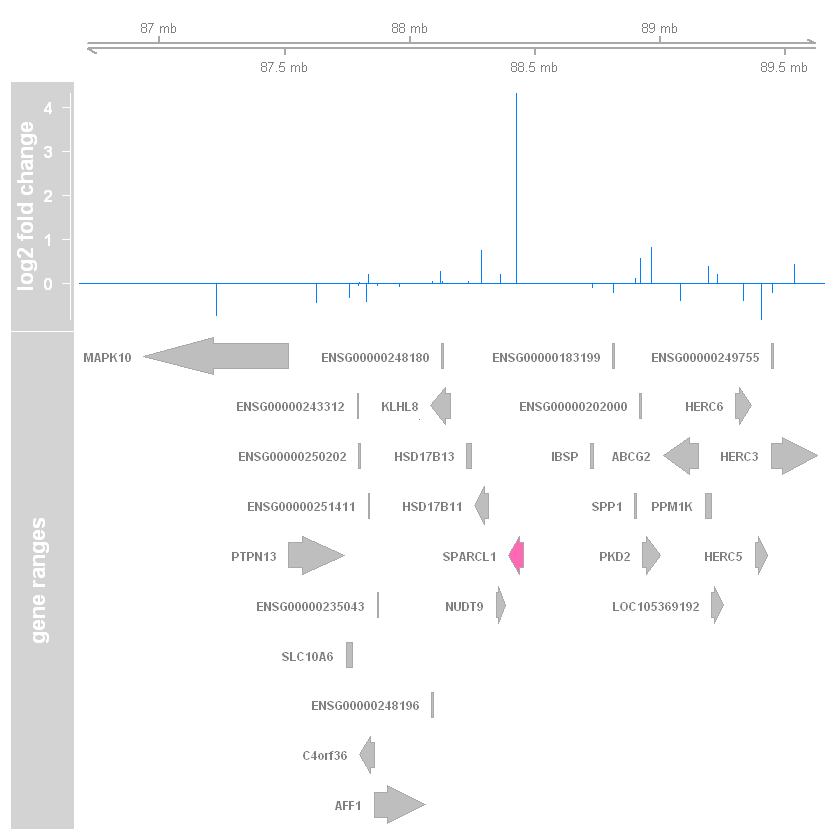

In [71]:
## ----gvizplot------------------------------------------------------------
options(ucscChromosomeNames = FALSE)
g <- GenomeAxisTrack()
a <- AnnotationTrack(resGRsub, name = "gene ranges", feature = status)
d <- DataTrack(resGRsub, data = "log2FoldChange", baseline = 0,
               type = "h", name = "log2 fold change", strand = "+")
plotTracks(list(g, d, a), groupAnnotation = "group",
           notsig = "grey", sig = "hotpink")


**log2 fold changes in genomic region surrounding the gene with smallest adjusted p value.** 
Genes highlighted in pink have adjusted p value less than 0.1.

## Removing hidden batch effects

Suppose we did not know that there were different cell lines involved in the experiment, only that there was treatment with dexamethasone. The cell line effect on the counts then would represent some hidden and unwanted variation that might be affecting many or all of the genes in the dataset. We can use statistical methods designed for RNA-seq from the sva [14] package (Leek 2014) to detect such groupings of the samples, and then we can add these to the DESeqDataSet design, in order to account for them. The SVA [14] package uses the term surrogate variables for the estimated variables that we want to account for in our analysis. Another package for detecting hidden batches is the RUVSeq package (Risso et al. 2014), with the acronym “Remove Unwanted Variation”.

In [72]:
## ------------------------------------------------------------------------
suppressPackageStartupMessages(library("sva"))


Below we obtain a matrix of normalized counts for which the average count across samples is larger than 1. As we described above, we are trying to recover any hidden batch effects, supposing that we do not know the cell line information. So we use a full model matrix with the dex variable, and a reduced, or null, model matrix with only an intercept term. Finally we specify that we want to estimate 2 surrogate variables. For more information read the manual page for the sva-seq function by typing *?svaseq*.

In [73]:
dat  <- counts(dds, normalized = TRUE)
idx  <- rowMeans(dat) > 1
dat  <- dat[idx, ]
mod  <- model.matrix(~ dex, colData(dds))
mod0 <- model.matrix(~   1, colData(dds))
svseq <- svaseq(dat, mod, mod0, n.sv = 2)
svseq$sv


Number of significant surrogate variables is:  2 
Iteration (out of 5 ):1  2  3  4  5  

0.2481108,-0.52600157
0.2629867,-0.58115433
0.1502704,0.27428267
0.2023800,0.38419545
-0.6086586,-0.07854931
-0.6101210,-0.02923693
0.1788509,0.25708985
0.1761807,0.29937417


Because we actually do know the cell lines, we can see how well the SVA [14] method did at recovering these variables (figure below).

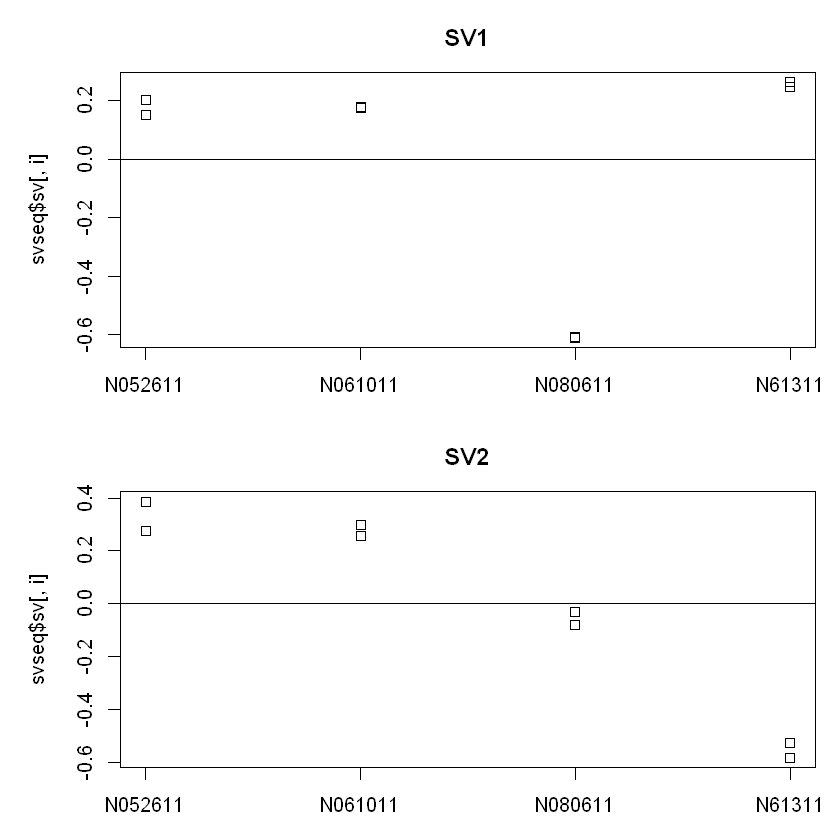

In [74]:
par(mfrow = c(2, 1), mar = c(3,5,3,1))
for (i in 1:2) {
  stripchart(svseq$sv[, i] ~ dds$cell, vertical = TRUE, main = paste0("SV", i))
  abline(h = 0)
 }

**Surrogate variables 1 and 2 plotted over cell line.** 
Here, we know the hidden source of variation (cell line), and therefore can see how the SVA [14] procedure is able to identify a source of variation which is correlated with cell line.

Finally, in order to use SVA [14] to remove any effect on the counts from our surrogate variables, we simply add these two surrogate variables as columns to the DESeqDataSet and then add them to the design:

In [75]:
## ------------------------------------------------------------------------
ddssva <- dds
ddssva$SV1 <- svseq$sv[,1]
ddssva$SV2 <- svseq$sv[,2]
design(ddssva) <- ~ SV1 + SV2 + dex

We could then produce results controlling for surrogate variables by running DESeq with the new design:

In [76]:
ddssva %<>% DESeq

using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


## Time course experiments

DESeq2 [8] can be used to analyze time course experiments, for example to find those genes that react in a condition-specific manner over time, compared to a set of baseline samples. Here we demonstrate a basic time course analysis with the fission [15] data package, which contains gene counts for an RNA-seq time course of fission [15] yeast (Leong et al. 2014). The yeast were exposed to oxidative stress, and half of the samples contained a deletion of the gene atf21. We use a design formula that models the strain difference at time 0, the difference over time, and any strain-specific differences over time (the interaction term strain:minute).

In [77]:
## ------------------------------------------------------------------------
library("fission")
data("fission")
ddsTC <- DESeqDataSet(fission, ~ strain + minute + strain:minute)

The following chunk of code performs a likelihood ratio test, where we remove the strain-specific differences over time. Genes with small p values from this test are those which at one or more time points after time 0 showed a strain-specific effect. Note therefore that this will not give small p values to genes that moved up or down over time in the same way in both strains.

In [78]:
## ----fissionDE-----------------------------------------------------------
ddsTC <- DESeq(ddsTC, test="LRT", reduced = ~ strain + minute)
resTC <- results(ddsTC)
resTC$symbol <- mcols(ddsTC)$symbol
head(resTC[order(resTC$padj),], 4)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


log2 fold change (MLE): strainmut.minute180 
LRT p-value: '~ strain + minute + strain:minute' vs '~ strain + minute' 
DataFrame with 4 rows and 7 columns
              baseMean log2FoldChange     lfcSE      stat       pvalue
             <numeric>      <numeric> <numeric> <numeric>    <numeric>
SPBC2F12.09c  174.6712    -2.65671953 0.7522613  97.28339 1.974151e-19
SPAC1002.18   444.5050    -0.05093214 0.2042995  56.95360 5.169552e-11
SPAC1002.19   336.3732    -0.39274898 0.5734940  43.53391 2.879804e-08
SPAC1002.17c  261.7731    -1.13876477 0.6061288  39.31584 2.051371e-07
                     padj      symbol
                <numeric> <character>
SPBC2F12.09c 1.334526e-15       atf21
SPAC1002.18  1.747308e-07        urg3
SPAC1002.19  6.489157e-05        urg1
SPAC1002.17c 3.466817e-04        urg2

This is just one of the tests that can be applied to time series data. Another option would be to model the counts as a smooth function of time, and to include an interaction term of the condition with the smooth function. It is possible to build such a model using spline basis functions within R, and another, more modern approach is using Gaussian processes (Tonner et al. 2017).

We can plot the counts for the groups over time using ggplot2, for the gene with the smallest adjusted p value, testing for condition-dependent time profile and accounting for differences at time 0 (figure below). Keep in mind that the interaction terms are the difference between the two groups at a given time after accounting for the difference at time 0.

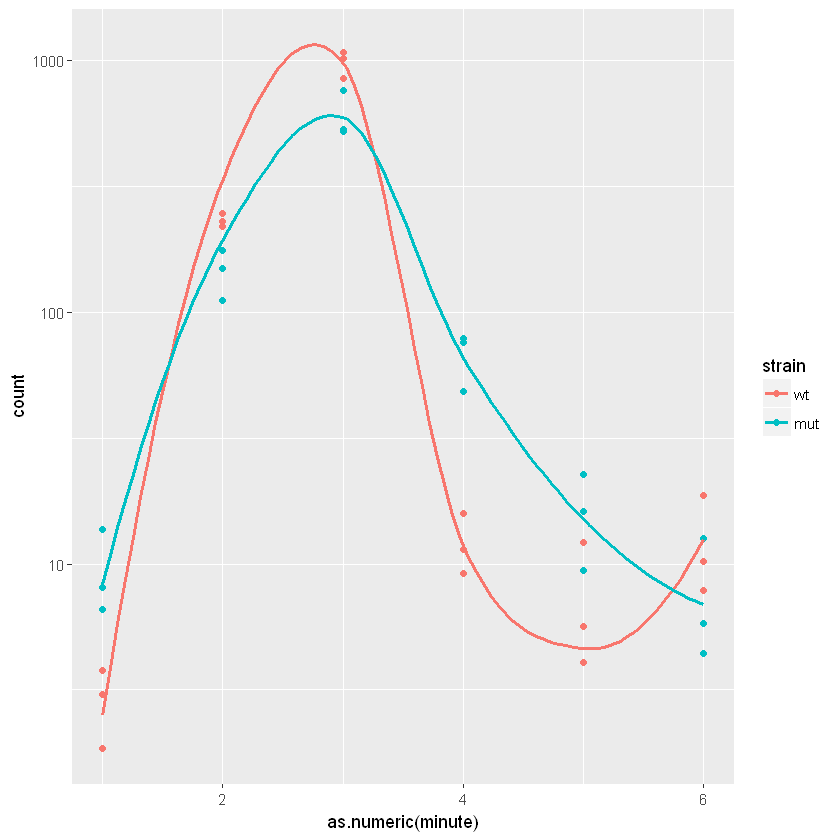

In [79]:
fiss <- plotCounts(ddsTC, which.min(resTC$padj), 
                   intgroup = c("minute","strain"), returnData = TRUE)
ggplot(fiss,
  aes(x = as.numeric(minute), y = count, color = strain, group = strain)) + 
  geom_point() + geom_smooth(se = FALSE, method = "loess") + scale_y_log10()

**Normalized counts for a gene with condition-specific changes over time.**

Wald tests for the log2 fold changes at individual time points can be investigated using the test argument to results:

In [80]:
## ------------------------------------------------------------------------
resultsNames(ddsTC)
res30 <- results(ddsTC, name="strainmut.minute30", test="Wald")
res30[which.min(resTC$padj),]


[1] "Intercept"           "strain_mut_vs_wt"    "minute_15_vs_0"     
 [4] "minute_30_vs_0"      "minute_60_vs_0"      "minute_120_vs_0"    
 [7] "minute_180_vs_0"     "strainmut.minute15"  "strainmut.minute30" 
[10] "strainmut.minute60"  "strainmut.minute120" "strainmut.minute180"

log2 fold change (MLE): strainmut.minute30 
Wald test p-value: strainmut.minute30 
DataFrame with 1 row and 6 columns
              baseMean log2FoldChange     lfcSE      stat       pvalue
             <numeric>      <numeric> <numeric> <numeric>    <numeric>
SPBC2F12.09c  174.6712      -2.600469 0.6343429 -4.099469 4.140994e-05
                  padj
             <numeric>
SPBC2F12.09c 0.2799312

We can furthermore cluster significant genes by their profiles. We extract a matrix of the shrunken log2 fold changes using the coef function:

In [81]:
## ------------------------------------------------------------------------
betas <- coef(ddsTC)
colnames(betas)

[1] "Intercept"           "strain_mut_vs_wt"    "minute_15_vs_0"     
 [4] "minute_30_vs_0"      "minute_60_vs_0"      "minute_120_vs_0"    
 [7] "minute_180_vs_0"     "strainmut.minute15"  "strainmut.minute30" 
[10] "strainmut.minute60"  "strainmut.minute120" "strainmut.minute180"

We can now plot the log2 fold changes in a heatmap (figure below).

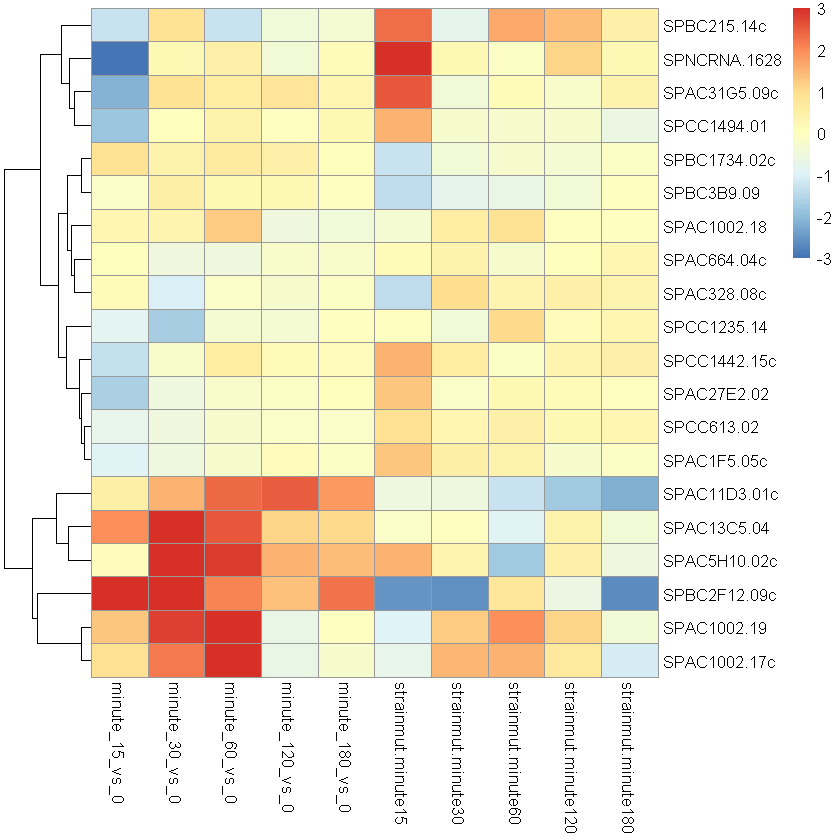

In [82]:
## ----fissionheatmap------------------------------------------------------
topGenes <- head(order(resTC$padj),20)
mat <- betas[topGenes, -c(1,2)]
thr <- 3 
mat[mat < -thr] <- -thr
mat[mat > thr] <- thr
pheatmap(mat, breaks=seq(from=-thr, to=thr, length=101),
         cluster_col=FALSE)

**Heatmap of log2 fold changes for genes with smallest adjusted p value.**

The bottom set of genes show strong induction of expression for the baseline samples in minutes 15-60 (red boxes in the bottom left corner), but then have slight differences for the mutant strain (shown in the boxes in the bottom right corner).

## Session Information

As the last part of this document, we call the function sessionInfo, which reports the version numbers of R and all the packages used in this session. It is good practice to always keep such a record of this as it will help to track down what has happened in case an R script ceases to work or gives different results because the functions have been changed in a newer version of one of your packages. By including it at the bottom of a script, your reports will become more reproducible.

The session information should also always be included in any emails to the Bioconductor support site along with all code used in the analysis.

In [83]:
## ------------------------------------------------------------------------
devtools::session_info()

Session info -------------------------------------------------------------------
Packages -----------------------------------------------------------------------


 setting  value                       
 version  R version 3.3.2 (2016-10-31)
 system   x86_64, mingw32             
 ui       RTerm                       
 language (EN)                        
 collate  English_United States.1252  
 tz       America/Los_Angeles         
 date     2017-05-14                  

 package                * version    date      
 acepack                  1.4.1      2016-10-29
 affy                     1.52.0     2016-10-18
 affyio                   1.44.0     2016-10-18
 airway                 * 0.108.0    2017-04-24
 annotate                 1.52.1     2016-12-22
 AnnotationDbi          * 1.36.2     2017-01-30
 AnnotationHub            2.6.5      2017-03-18
 assertthat               0.2.0      2017-04-11
 backports                1.0.5      2017-01-18
 base64enc                0.1-3      2015-07-28
 beeswarm                 0.2.3      2016-04-25
 Biobase                * 2.34.0     2016-10-18
 BiocGenerics           * 0.20.0     2016-10-18
 BiocInstaller 

# References

[1] [Bioconductor RNA-seq workflow](https://www.bioconductor.org/help/workflows/rnaseqGene/#introduction)

### Bioconductor Packages:

[2] 
Himes BE, Jiang X, Wagner P, Hu R, Wang Q, Klanderman B, Whitaker RM, Duan Q, Lasky-Su J, Nikolos C, Jester W, Johnson M, Panettieri R Jr, Tantisira KG, Weiss ST, Lu Q. 'RNA-Seq Transcriptome Profiling Identifies CRISPLD2 as a Glucocorticoid Responsive Gene that Modulates Cytokine Function in Airway Smooth Muscle Cells.' PLoS One. 2014 Jun 13;9(6):e99625. PMID: 24926665.

[3]
Andrzej Oles, Martin Morgan and Wolfgang Huber (2016). BiocStyle:
  Standard styles for vignettes and other Bioconductor documents. R
  package version 2.2.1. https://github.com/Bioconductor/BiocStyle

[4]
Martin Morgan, Herv\'e Pag\`es, Valerie Obenchain and Nathaniel
  Hayden (2017). Rsamtools: Binary alignment (BAM), FASTA, variant call
  (BCF), and tabix file import. R package version 1.26.2.
  http://bioconductor.org/packages/release/bioc/html/Rsamtools.html

[5]
Lawrence M, Huber W, Pag\`es H, Aboyoun P, Carlson M, et al. (2013)
  Software for Computing and Annotating Genomic Ranges. PLoS Comput
  Biol 9(8): e1003118. doi:10.1371/journal.pcbi.1003118
  
[6]
Lawrence M, Huber W, Pag\`es H, Aboyoun P, Carlson M, et al. (2013)
  Software for Computing and Annotating Genomic Ranges. PLoS Comput
  Biol 9(8): e1003118. doi:10.1371/journal.pcbi.1003118
  
[7]
Martin Morgan, Valerie Obenchain, Michel Lang and Ryan Thompson
  (2017). BiocParallel: Bioconductor facilities for parallel
  evaluation. R package version 1.8.2.
  https://github.com/Bioconductor/BiocParallel
  
[8]
Michael I Love, Wolfgang Huber and Simon Anders (2014): Moderated
  estimation of fold change and dispersion for RNA-Seq data with
  DESeq2. Genome Biology
  
[9]
Wolfgang Huber, Anja von Heydebreck, Holger Sueltmann, Annemarie
  Poustka and Martin Vingron. Variance Stabilization Applied to
  Microarray Data Calibration and to the Quantification of Differential
  Expression. Bioinformatics 18, S96-S104 (2002).
  
[10]
R. Gentleman, V. Carey, W. Huber and F. Hahne (2016). genefilter:
  genefilter: methods for filtering genes from high-throughput
  experiments. R package version 1.56.0.
  
[11] 
Hervé Pagès, Marc Carlson, Seth Falcon and Nianhua Li (2017).
  AnnotationDbi: Annotation Database Interface. R package version
  1.36.2
  
[12]
Marc Carlson (2016). org.Hs.eg.db: Genome wide annotation for Human.
  R package version 3.4.0.
  
[13]
Hahne F, Ivanek R. Visualizing Genomic Data Using Gviz and
  Bioconductor. Methods Mol Biol. 1418:335-51 (2016).
  
[14]
Jeffrey T. Leek, W. Evan Johnson, Hilary S. Parker, Elana J. Fertig,
  Andrew E. Jaffe and John D. Storey (2016). sva: Surrogate Variable
  Analysis. R package version 3.22.0.
  
[15]
Leong HS, Dawson K, Wirth C, Li Y, Connolly Y, Smith DL, Wilkinson
  CR, Miller CJ. 'A global non-coding RNA system modulates fission
  yeast protein levels in response to stress'. Nat Commun 2014 May
  23;5:3947. PMID: 24853205